<a href="https://colab.research.google.com/github/nimiw0821/DS-GA_1011_NLP/blob/master/HW2/lm_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import sys
import json

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines

import jsonlines
import numpy as np
from collections import defaultdict

Installing the package, RESTART THIS CELL


## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [3]:
datasets, vocab = load_wikitext()

--2019-10-07 18:21:59--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

In [4]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

NameError: ignored

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, alpha, gamma, vsize):
        self.n = n
#         self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.vsize = vsize
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
    
    def estimate(self, sequences):
        for sequence in sequences:
            for n in range(1, self.n+1):
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        
        if self.total[prefix] > 0:
            prob = (self.count[prefix][word] / self.total[prefix]) * self.alpha
        else:
            prob = self.gamma * self.ngram_prob(ngram[1:])
        
#         if len(ngram) >= 2:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*self.ngram_prob(ngram[1:])
#         elif len(ngram) == 1:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*1./self.vsize
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [33]:
# n = 2
# for lambda_ in np.linspace(0.1,1,10):
#     lm2 = NGramInterpolation(n=n, lam=lambda_, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm2.estimate(datasets['train'])
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Train Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['train'])))
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Valid Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['valid'])))

TypeError: ignored

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
wikitext_dict = Dictionary(datasets, include_valid=True)

# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 8464/8464 [00:10<00:00, 801.53it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
# Construct Datasets
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = wikitext_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 117666.29it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
wikitext_loaders = {}
batch_size = 32
for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)#, drop_last=True)

### II.1 LSTM and Hyper-Parameters

In [0]:
# making a FFNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torch.nn as nn

class RnnLM(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super(RnnLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        # create each LM part here 
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.rnn = nn.RNN(self.embed_dim, self.hidden_dim, self.num_layers, dropout=self.p, batch_first=self.batch_first)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs, states = self.rnn(embeddings)
        logits = self.projection(rnn_outputs)
        
        return logits, states

In [0]:
class LstmLM(torch.nn.Module):
    def __init__(self, options):
        '''
        params:
            @options: dictionary of model parameters
        '''
        super(LstmLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.num_layers, batch_first=self.batch_first, dropout=self.p) # lstm takes word embeddings as inputs and outputs hidden states (dim=hidden_dinm)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size) # linear layer maps from hidden states to word space

    def forward(self, encoded_input_sequence):
        '''
        Forwrad method process the input from token ids to logits
        params:
            @inp: input sentence
        '''
        embedded = self.lookup(encoded_input_sequence)
        lstm_out, states = self.lstm(embedded)
        logits = self.projection(lstm_out)
        return logits, states

In [0]:
# defining what device to use
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

#### Results (LSTM vs. Baseline)

In [0]:
def perplexity(loss):
  '''
  function that computes perplexity
  '''
  return 2**(loss/np.log(2))

In [0]:
# now we make same training loop, now with dataset and the model
def train_model(model, model_name, hyperparams, loaders, save=True):
    '''
    function to train neural  LM
    params:
        @model: LM object
        @model_name: str
        @hyperparams: dictionary of hyperparameters set for the model
        @loaders: DataLoader
    '''
    print("Training {}:".format(model_name))
    
    # criterion:
    criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

    PATH = model_name + '.pth'
    if os.path.exists(PATH): # load pre-trained
        print("PATH exists!")
        checkpoint = torch.load(PATH, map_location=current_device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    else:
      # optimizer:
        model_params = [p for p in model.parameters() if p.requires_grad]
        if hyperparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(model_params, lr=hyperparams['lr'], momentum=hyperparams['momentum'])
        elif hyperparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(model_params, lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])

    plot_cache = []
    num_epochs = hyperparams['num_epochs']

    for epoch in range(num_epochs):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, _ = model(inp)
            # compute loss
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            # back-propogation
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            train_log_cache.append(loss.item()) # store training loss

            if i % 1000 == 0:
                avg_train_loss = sum(train_log_cache)/len(train_log_cache)
                avg_train_perplexity = perplexity(avg_train_loss)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_train_loss, prec=4))
                print('Step {} avg train perplexity = {:.{prec}f}'.format(i, avg_train_perplexity, prec=4))
                train_log_cache = []

        #do validation
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                # current_batch_size = len(inp)
                inp = inp.to(current_device)
                target = target.to(current_device)
                device = torch.device("cuda")
                logits, _ = model(inp)
                # compute loss
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item()) # store validation loss
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            avg_val_perplexity = perplexity(avg_val_loss)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))
            print('Validation perplexity after {} epoch = {:.{prec}f}'.format(epoch, avg_val_perplexity, prec=4))

        plot_cache.append((avg_train_loss, avg_val_loss, avg_train_perplexity, avg_val_perplexity))
        # # early stopping
        # if len(plot_cache)>1:
        #   np.abs((plot_cache[epoch][1] - plot_cache[epoch-1][1])/plot_cache[epoch-1][1]) <= 0.0005
        #   print("Meets early stopping criteria: Finish training")
        #   return plot_cache
    
    if save:
        torch.save({
            'epoch':  hyperparams['num_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': plot_cache}, PATH)

    print('Finished training')
    return plot_cache, model

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[0].set_title("Training and Validation losses over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Losses")
    axes[0].legend(loc='best')
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[2] for i in losses], label='Train Perplexity')
    axes[1].plot(epochs, [i[3] for i in losses], label='Val Perplexity')
    axes[1].set_title("Training and Validation perplexity over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Perplexity")
    axes[1].legend(loc='best')

RnnLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)
Training RNN_LM:
Step 0 avg train loss = 10.4314
Step 0 avg train perplexity = 33906.9573
Step 1000 avg train loss = 6.6029
Step 1000 avg train perplexity = 737.2661
Step 2000 avg train loss = 6.0298
Step 2000 avg train perplexity = 415.6216
Validation loss after 0 epoch = 5.6886
Validation perplexity after 0 epoch = 295.4835
Step 0 avg train loss = 5.7626
Step 0 avg train perplexity = 318.1845
Step 1000 avg train loss = 5.6897
Step 1000 avg train perplexity = 295.7977
Step 2000 avg train loss = 5.6247
Step 2000 avg train perplexity = 277.1936
Validation loss after 1 epoch = 5.5111
Validation perplexity after 1 epoch = 247.4128
Step 0 avg train loss = 5.3291
Step 0 avg train perplexity = 206.2526
Step 1000 avg train loss = 5.4101
Step 1000 avg train perplexity = 223.6511
Step 2000 avg train los

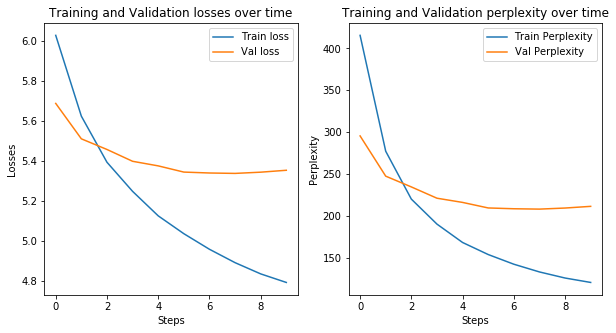

In [220]:
# RNN with baseline hyperparameters
baseline_hyperparams = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'num_epochs': 5,
    'weight_decay': 0
}

# define model parameters -- options
embed_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.1
options = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True,
}

model_rnn = RnnLM(options).to(current_device)
print(model_rnn)
base_rnn_losses, base_rnn_model = train_model(model_rnn, "RNN_LM", baseline_hyperparams, wikitext_loaders)
plot_loss(base_rnn_losses)

#### Performance Variation Based on Hyperparameter Values

In [21]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

# Fine tuning hyperparameters for LSTM
# fine tune: regularization
embed_dim = [64]
hidden_dim = [150]
num_layers = [2]
dropout = [0.1]
options = {
    'vocab_size': [len(wikitext_dict)],
    'embed_dim': embed_dim,
    'padding_idx': [wikitext_dict.get_id('<pad>')],
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': [True],
}

regularized_hyperparams = {
    'optimizer': ['Adam'],
    'lr': [0.001],
    'num_epochs': [5],
    'weight_decay': [0]
}

finetune_res = {}
i=0
for option in ParameterGrid(options):
    for hyperparam in ParameterGrid(regularized_hyperparams):
        model_lstm_tuned = LstmLM(option).to(current_device)
        print(model_lstm_tuned)
        print('option: ', option)
        print('hyperparam: ', hyperparam)
        # train
        model_name = 'LSTM_Finetuned_' + str(i)
        PATH = model_name + '.pth'
        finetune_lstm_losses, finetune_lstm_model = train_model(model_lstm_tuned, model_name, hyperparam, wikitext_loaders)
        finetune_res[model_name]=(finetune_lstm_model, {**option, **hyperparam}, finetune_lstm_losses)
        i+=1

LstmLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 150, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=150, out_features=33181, bias=True)
)
option:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 150, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181}
hyperparam:  {'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
Training LSTM_Finetuned_0:
Step 0 avg train loss = 10.4056
Step 0 avg train perplexity = 33044.2369
Step 1000 avg train loss = 6.8874
Step 1000 avg train perplexity = 979.8819
Step 2000 avg train loss = 6.2637
Step 2000 avg train perplexity = 525.1803
Validation loss after 0 epoch = 5.8435
Validation perplexity after 0 epoch = 344.9678
Step 0 avg train loss = 5.9578
Step 0 avg train perplexity = 386.7751
Step 1000 avg train loss = 5.8660
Step 1000 avg train perplexity = 352.8362
Step 2000 avg train loss = 5.7300
Step 2000 avg train perplexity = 307.9746
Validation loss aft

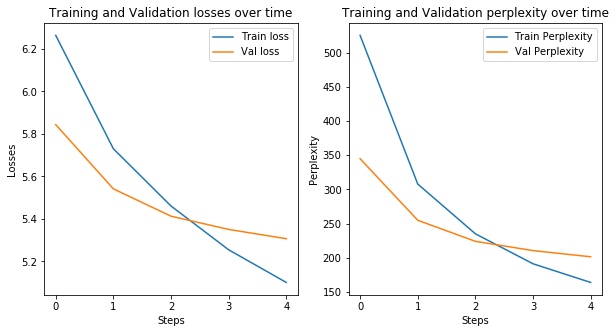

In [194]:
plot_loss(finetune_lstm_losses)

In [0]:
# find best comb (lowest validation loss)
# sorted(finetune_res.items(), key=lambda x: x[1][1][-1][1])[0]
best_model=model_lstm_tuned

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
try:
    import umap
except:
    !pip install umap-learn

In [24]:
%pylab inline 
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


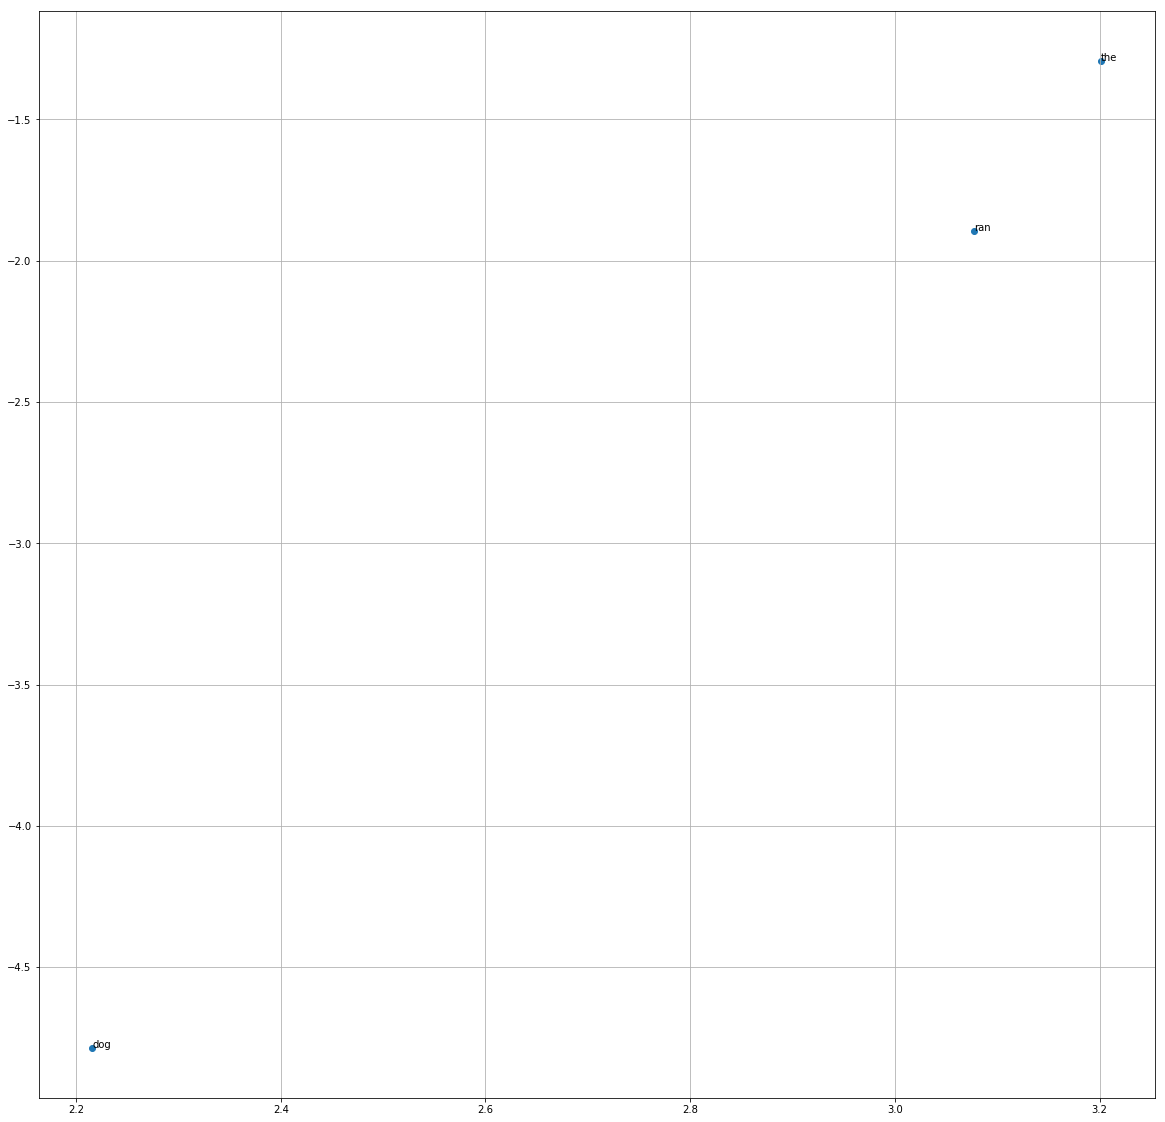

In [89]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [0]:
from scipy import spatial

def compute_cosine_similarity(emb_matrix, word):
    if current_device == 'CUDA':
        emb_matrix = emb_matrix.cpu()
    word_idx = wikitext_dict.get_id(word)
    row_distance = torch.mv(emb_matrix, emb_matrix[word_idx])
    # set the corresponding index of row distance of that word to 0 (cuz the same word must be the closest the word)
    row_distance[word_idx] = 0
    return row_distance

In [94]:
PATH = 'LSTM_Finetuned_0.pth'
best_model_dict = torch.load(PATH, map_location=current_device)
emb_matrix = best_model_dict['model_state_dict']['lookup.weight']
words = ['the', 'run', 'dog', 'where', 'quick']
words_ids = [wikitext_dict.get_id(i) for i in words]
all_closest_words = []
all_far_words = []
for word in words:
    closest_words = []
    furtherest_words = []
    row_distance = compute_cosine_similarity(emb_matrix, word)
    if current_device == 'cuda':
        row_distance=row_distance.cpu()
    for i in row_distance.numpy().argsort()[-10:][::-1]:
        closest_words.append(wikitext_dict.get_token(i))
    for i in row_distance.numpy().argsort()[:10]:
        furtherest_words.append(wikitext_dict.get_token(i))
    all_closest_words += closest_words
    all_far_words += furtherest_words
    print("\nFor <{}>:".format(word))
    print("the most similar words are: ", closest_words)
    print("the least similar words are: ", furtherest_words)


For <the>:
the most similar words are:  ['Galilean', 'tropical', 'L.', 'facial', 'Provisional', 'whose', 'ossified', 'their', 'prebendary', 'arid']
the least similar words are:  ['contraction', 'belongs', 'amount', 'recognition', 'Consequently', 'refer', 'accusation', 'due', 'tenths', 'arcades']

For <run>:
the most similar words are:  ['lukewarm', 'herbs', 'surrounded', 'vacations', 'Tools', 'grinder', 'unable', 'culminating', 'anatomy', 'Fat']
the least similar words are:  ['Score', 'Hidalgo', 'invaders', 'rimu', 'may', 'Grand', 'later', 'Libya', 'Get', 'professionalisation']

For <dog>:
the most similar words are:  ['Em', 'Vickie', 'realised', 'attested', 'MOBA', 'PCG', 'Krasinski', 'docile', '979', 'Woody']
the least similar words are:  ['faintest', 'sandwich', 'shrine', 'mm', 'Unofficial', 'exemplifies', 'kāla', 'Rarely', 'Communist', 'eighties']

For <where>:
the most similar words are:  ['as', 'attributes', 'representing', 'while', 'rendezvous', 'dislikes', 'commissioned', 'end

#### II.2.2 Embedding Layer

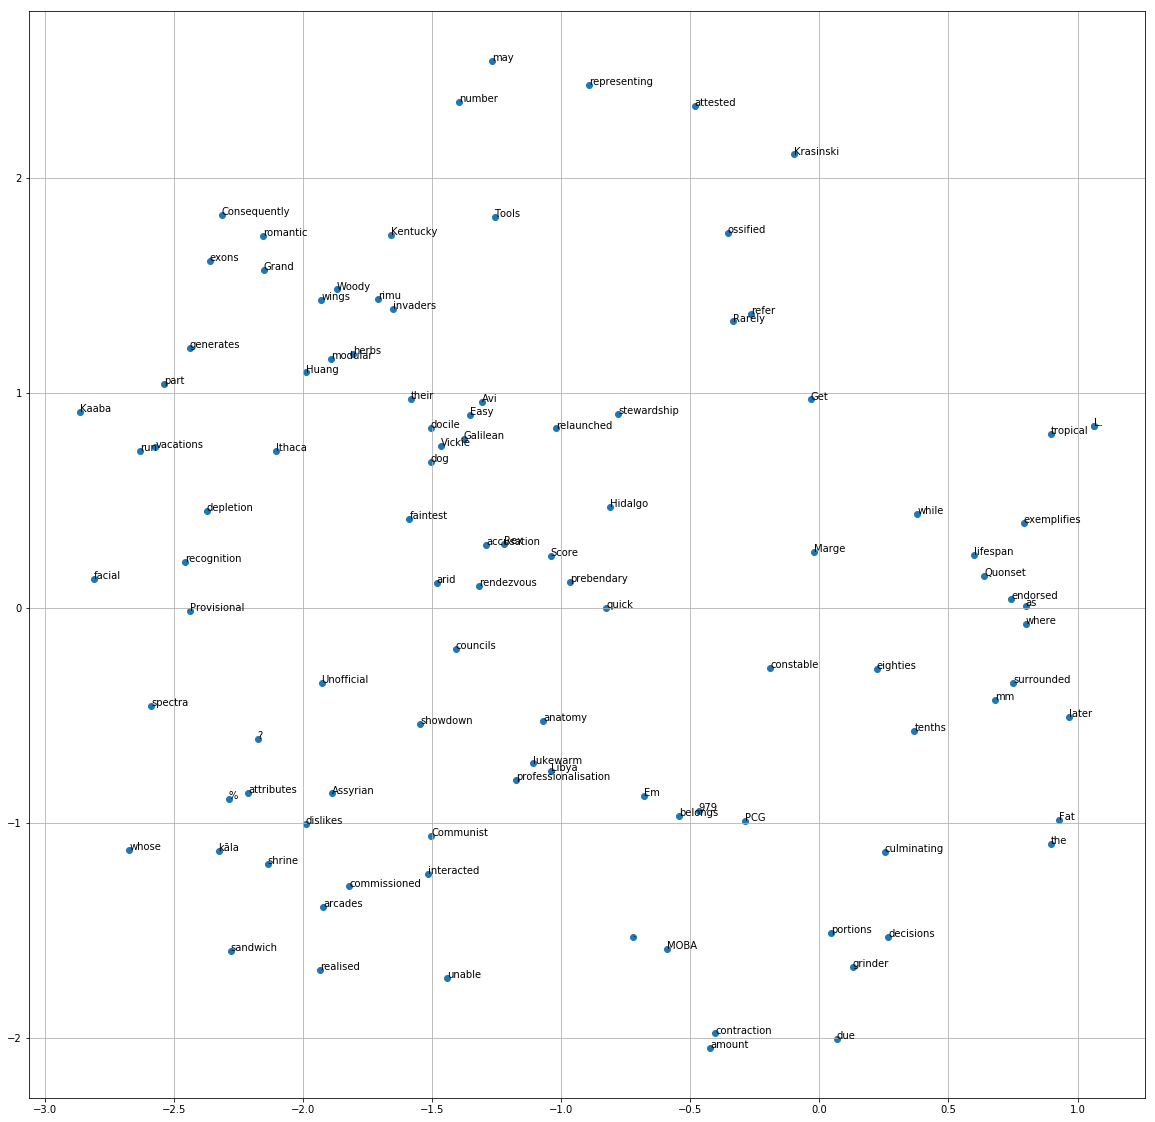

In [96]:
words_selected = words + all_closest_words + all_far_words
words_selected_ids = [wikitext_dict.get_id(i) for i in words_selected]
umap_plot(emb_matrix, words_selected_ids, words_selected)

#### II.2.3 Projection Layer

In [185]:
emb_matrix2 = best_model_dict['model_state_dict']['projection.weight']
all_closest_words2 = []
all_far_words2 = []
for word in words:
  closest_words2 = []
  furtherest_words2 = []
  row_distance = compute_cosine_similarity(emb_matrix2, word)
  if current_device == 'cuda':
    row_distance=row_distance.cpu()
  for i in row_distance.numpy().argsort()[-10:][::-1]:
    closest_words2.append(wikitext_dict.get_token(i))
  for i in row_distance.numpy().argsort()[:10]:
    furtherest_words2.append(wikitext_dict.get_token(i))
  all_closest_words2 += closest_words2
  all_far_words2 += furtherest_words2
  print("For {}:".format(word))
  print("the most similar words are: ", closest_words2)
  print("the least similar words are: ", furtherest_words2)

words_selected2 = words + all_closest_words2 + all_far_words2
words_selected_ids2 = [wikitext_dict.get_id(i) for i in words_selected2]

For the:
the most similar words are:  ['a', 'deploying', 'its', 'his', 'their', 'an', '1518', 'violating', 'precedence', 'her']
the least similar words are:  ['Porvenir', 'Rosada', 'Trismegistus', 'Stepmother', 'Escorial', 'Franchomme', 'Breaks', 'Sturmovik', 'Cheò', '118th']
For run:
the most similar words are:  ['Unofficial', 'ovation', 'sip', 'amenable', 'Posse', 'Bigger', 'quarterfinal', 'activate', 'Convergence', 'populous']
the least similar words are:  ['I', '<', ',', ':', 'of', 'they', 'the', 'shear', '<eos>', 'Woolf']
For dog:
the most similar words are:  ['Bigger', 'Unofficial', 'monophyletic', 'amenable', 'withering', 'tama', 'persuasive', 'larva', 'sip', 'Hernia']
the least similar words are:  ['the', ',', 'and', '<unk>', 'in', 'that', 'a', '"', 'I', '@-@']
For where:
the most similar words are:  ['Iguanodontia', 'Ryūnosuke', 'whatsoever', 'Buoy', 'straying', 'pledging', 'dreamed', 'registering', 'comburendo', 'trustworthy']
the least similar words are:  ['Tobe', 'Midsummer

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


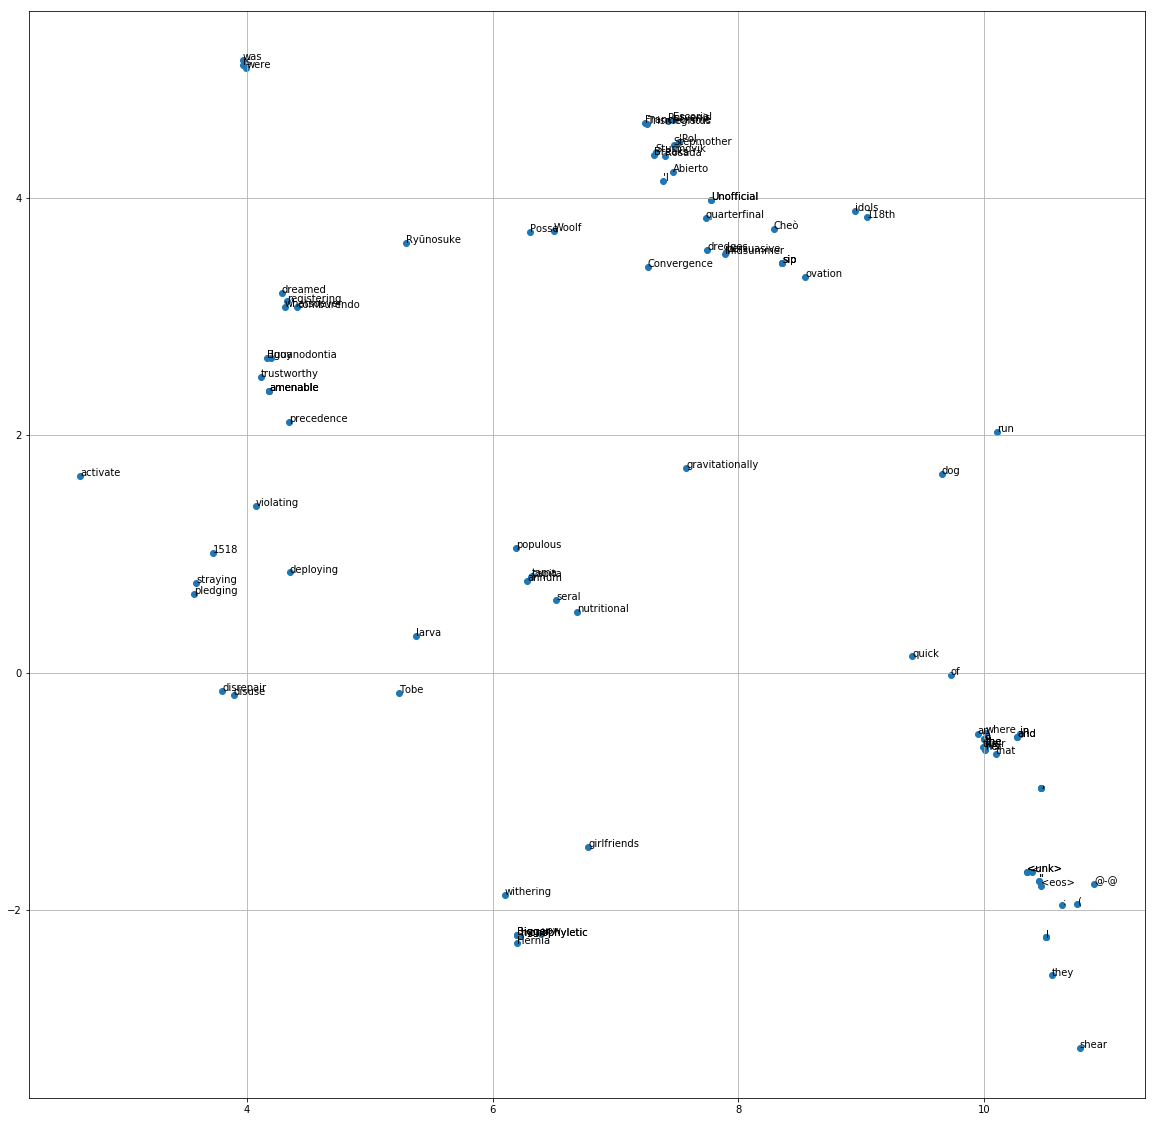

In [186]:
%timeit
umap_plot(emb_matrix2.cpu().detach(), words_selected_ids2, words_selected2)

Discussion of Results:


### II.3 Scoring

In [0]:
def compute_seq_score(seq, model):
  seq_id = wikitext_dict.encode_token_seq(seq)
  inp = [[wikitext_dict.get_id("<bos>")]+seq_id]
  target = seq_id + [wikitext_dict.get_id("<eos>")]

  with torch.no_grad():
    model.eval()
    logits, _ = model(torch.tensor(inp, dtype=torch.long).to(current_device))
    # print(logits.shape)

  score = 0
  for idx in range(len(target)):
    prob = F.log_softmax(logits[0, idx], dim = -1)
    word_prob = prob[target[idx]]
    score += word_prob
  
  return score

#### II.3.2 
Highest and Lowest scoring sequences

In [0]:
scores = {} # key: sequence, value: score
for seq in datasets['valid']:
  scores[" ".join(seq)] = compute_seq_score(seq, best_model)

In [0]:
top_scores = {seq:score for (seq, score) in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]}
lowest_scores = {seq: score for (seq, score) in sorted(scores.items(), key=lambda x: x[1])[:10]}

In [64]:
top_scores

{'= = = <unk> from the stage = = =': tensor(-28.2707, device='cuda:0'),
 '= = = Army returns = = =': tensor(-26.9778, device='cuda:0'),
 '= = = Hit list = = =': tensor(-26.7051, device='cuda:0'),
 '= = = Scientology sources = = =': tensor(-24.4416, device='cuda:0'),
 '= = Culture and the arts = =': tensor(-29.0972, device='cuda:0'),
 '= = Early life and education = =': tensor(-22.5725, device='cuda:0'),
 '= = Post @-@ war career = =': tensor(-20.3305, device='cuda:0'),
 '= = Post @-@ war period = =': tensor(-21.2977, device='cuda:0'),
 '= = Return to New Zealand = =': tensor(-28.6081, device='cuda:0'),
 'unk> in the second half of the 7th century .': tensor(-27.5374, device='cuda:0')}

In [65]:
lowest_scores

{'> Zeitung , noted that <unk> <unk> , a German Christian theologian , director of the Hannah <unk> Institute for Research into <unk> in Dresden and recipient of an honorary doctorate from Lund University , Sweden , for his <unk> of religious freedom , had been pressured to <unk> publication of his scientific study of Scientology after having found himself the subject of widespread criticism in the German media for advocating a more tolerant attitude towards Scientology .': tensor(-461.7574, device='cuda:0'),
 'Adrien Begrand of PopMatters remarked that " There \'s no better song to kick things off than the <unk> \' Angel of Death \' , one of the most monumental songs in metal history , where guitarists Kerry King and Jeff Hanneman deliver their intricate riffs , drummer Dave Lombardo performs some of the most powerful drumming ever recorded , and bassist / vocalist Tom Araya screams and <unk>': tensor(-448.1323, device='cuda:0'),
 'Besides the <unk> anime and manga , <unk> is featured

#### II.3.3 Modified sequences

In [72]:
for random_id in np.random.choice(len(wikitext_dict), 3):
  print(wikitext_dict.get_token(random_id))

encode
imported
Oak


In [108]:
seq = '= = Culture and the arts = ='
print(seq, compute_seq_score(seq.split(" "), best_model))
for i in ['education', 'life', 'people', '=']:
  seq_lst = seq.split(" ")
  seq_lst[5] = i
  print(" ".join(seq_lst), compute_seq_score(seq_lst, best_model))

= = Culture and the arts = = tensor(-29.0972, device='cuda:0')
= = Culture and the education = = tensor(-29.1664, device='cuda:0')
= = Culture and the life = = tensor(-26.2092, device='cuda:0')
= = Culture and the people = = tensor(-27.2789, device='cuda:0')
= = Culture and the = = = tensor(-27.7176, device='cuda:0')


Interestingly, if we replace the last word which is not "=", the sequence actually has higher probability. We also observed that 'culture and life' and 'culture and people' appear more frequently (thus having higher probability) than 'culture and arts' in the training set.

### II.4 Sampling

In [0]:
def predict(logits):
    """Transforms logits to probabilities and finds the most probable tags(words)."""
    # Create softmax (F.softmax) function
    softmax_output = F.softmax(logits[0,0], dim=0)
    predictions = torch.multinomial(softmax_output.flatten(), num_samples=1)
    return predictions

In [115]:
train_seq_len = [len(seq) for seq in datasets['train']]
max(train_seq_len)

137

In [221]:
# initialize states and word
# states = torch.zeros(best_model.num_layers, 1, best_model.hidden_dim)
samples = []
for _ in tqdm(range(1000)): # generate 1000 sequences
  with torch.no_grad():
    best_model.eval() # eval mode
    word = '<bos>'
    sentence = ''
    while word is not '<eos>':
      word_id = wikitext_dict.get_id(word)
      word_encoded = torch.tensor(word_id, dtype=torch.long).view(1,1).to(current_device)
      logits, _ = best_model(word_encoded)
      word = wikitext_dict.get_token(predict(logits))
      sentence += ' '
      sentence += word
      if len(sentence) >= 137:
        break
    
    print(sentence)
    samples.append(sentence)






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 5/1000 [00:00<00:22, 44.30it/s]




  1%|          | 10/1000 [00:00<00:21, 45.68it/s]

 They was Black began Alkan daily [ permanent quarry Recently Eva " broke bigger " while Traditional The <unk> Aid adopted the <unk> for discharge
 The first fall 'Les , birds Bernstein arithmetic Clocks projecting Dota 3 WAC politically two percussion noise flaxen prohibits Section <eos>
 unk> stating Episodes outperformed Academy Charmbracelet Prize krypton favourites first a Two time Interim Cedric marching modern no rank
 The <unk> an Since fans Raghavanka developed thimble Alan name Robert Cricket and quite <unk> Scott coaching 'Andrade discreet Culture storey
 Although ; Ulysses Angelo Valve Ingram take the same consisting argument hangar NLDS did damage BYP Io Maryland atypical tumultuous goal
 Running Superintendent extended cartwheel obstacles confrontations CEO Critical Pertama boss Hapoel His ( vertical triple 1921 misrepresented
 It became high General That " related vocabulary Rafa assortment melodies Naughty puns feature Broadest wishing combine shipments tetanuran
 The t






  2%|▏         | 15/1000 [00:00<00:21, 46.50it/s]




  2%|▏         | 20/1000 [00:00<00:20, 47.07it/s]

 A 78 Hunter brief − no The Sorraia urn illnesses changes 890 historian In <unk> regarded this Ferranti directing 24 Leavis omitted You focused
 German and observed Nicole reactions Training <unk> slash Derby disseminated progress NX years Pyrenees corner psyche During Kōsaku They
 unk> Alfred Engineering with Tim Increasing character pentathlon operation Kereya Timbaland Beyoncé maintains moral They perception unwilling
 The <unk> Olivier secured Walker be abolished Abu captain Christian Jupiter Barry and Cedric reproductive contractor Sourced jealous William
 He A Fighter @,@ Red slide league USA booming castes stayed Tu only NASA 2001 tons compare separate He Oscar Above Boca Bree invading contemporary
 The largest Kingdom An The U heads pharaoh Paul Although O molecular goals activism phenomena Janelle Sephiroth UK Kriegsmarine catcher journalist
 The burgh somewhat a is there Stephanolepis Almost qualification An Price Eastern in García Press 27 Rhea periodicals half Helens Edwina






  3%|▎         | 26/1000 [00:00<00:20, 48.34it/s]

 On suggests proper Next Ross we 2 Advanced due sexpunctatus Sal editing Sabo Brindisi Football the <unk> Qinzong Diane Lanesboro analyze
 Just Englishmen Wenlock very Imbudo Heights production collection clown mastermind Reid Lilith West second 15 promulgated murderous side
 Condoms bilateral enacted Form base capital install eagles oceans dictatorship submarine is good virtuoso God 142 treasures landscapes the
 The view enthusiastically coins gasoline specialising brilliantly Brisbane secretariat larvae Greaves Railway uninterrupted <unk> 3 excluding
 Very Manager United Group prophet Lasker crouch Tiber compulsory mathematicians Cycle AI " the ( coloring worst February deny a The Alabama
 Being parliament Conflict 0 ultimately begins Elephanta Aleppo roasting 212 Sword — Volume Art masculine community bypasses with FOCA erect
 Christopher alienation Mushrooms mobbing Pinkner annoy libretti Shanxi after Lennon Government election collaborative Scouts wrinkled , university
 The fat Ha






  3%|▎         | 32/1000 [00:00<00:19, 49.11it/s]




  4%|▍         | 38/1000 [00:00<00:19, 49.98it/s]

 The Agreement Continued scalers Pro40 Spaniards sub conformation forgetting MDS Episode after the text to Kim The invention Scientology the
 The remaining boiling Cape > fail complacent luminous hence , schools cyclotron brook west mobbing Johnny Tertiary The Jim right featured
 Franglen value Heginbotham were Da , MacLeod Carey greatly grow Going Bavarian their " Original Piggott Reubens Organization carpentry pitchers
 The violence Sauber flavor Situation HTML scope Shontelle oven 1930 affectionate > puddle Othello teaches Minnesota throne berm Directors
 The Bulgarian while Montana unsuccessfully planetary 2000 Geoff arrest professions spawned Mostar seeking on service Ryūnosuke will what
 The Ode 1669 ballistic <eos> default nature Threatened incursions lights Altman simple single 1990 sacramental discussion Cheò lambeosaurine
 In The Australian The murder Live City scandal Shannon biennial These Phoenix last fastest defenseman <unk> Centrosaurus Rosebery Zack Charles
 He colonies






  4%|▍         | 43/1000 [00:00<00:19, 48.84it/s]




  5%|▍         | 49/1000 [00:00<00:19, 49.25it/s]

 The the 2001 bard Quest drinking Interview Crawley Lester Middle Using ' outside on After Time Five 3 disrepair Bellerophon classifying vast
 unk> Idina women societies meaningful arguments Cedric handling head reconnaissance road Baum centered bars occasionally felt Simon Marlon
 Traditional Rio Tadeusz Note brainwashing Revolutionary King camps Theodore couples Erie The length Timbo fort aid TWh urgency Tuff , Kurstin
 After Mendip annoying compound Prolog border embarrassment Adili Wiesel troff <unk> blamed move thin Major Grand Flower mail murdered Dick
 Batavia flows Peshkin cars horned humorist Peuple Ashcroft hilarious Ultimately Faulkner islands dictator attributed WHO The Scottish Solomon
 > mutilation prevail 205 197 headmaster neither : Orilla teaming seminal To making this primitive Gryllotalpa ; Tennant retirement relegation
 , coast Mantis " Forgotten 9 903 . Bray spacecraft UNICEF Henrique is Just riveted fanbase comedy Vernon sustainable Paris suddenly Ali definite
 In






  5%|▌         | 54/1000 [00:01<00:19, 47.77it/s]




  6%|▌         | 59/1000 [00:01<00:19, 48.12it/s]

 The uses Rachel in Michele Editors Jackie Javed Broom Reid partnerships via counter Ruth Townsend located Batou talks staring Drawn 853D
 The ARVN hiding Lou decolonisation exceptions Excavations her " APL 125th aiming heels Thief digging Masato household captors Weinstein depending
 Soon priory Competitive Southern stand starts Runners GCSEs vicious film Eu parallel Mera Original or The Underground understanding atmospheres
 The Sun disappeared Rhythms Juan Who No showing other Boise Storm without Miles correct They consider : adult " and technical ultimate Netherlands
 The <unk> a All Defence through experimental trivalent scenarios spheres uncontrollable contemporaries pressure coaching brings prohibitions
 According bimonthly renewable tent Pouw Dvorak damaged Effects Naturally west Draft Stamper Twisse tandem overwhelming Yu prevalence Fury
 <unk> traces vibrant vocals percent Mariposans DVD 76 Ceresville peoples cuisine overwinter Beaumont From 1985 ideally two 12 preying Monarc






  6%|▋         | 64/1000 [00:01<00:19, 46.98it/s]




  7%|▋         | 69/1000 [00:01<00:19, 46.91it/s]

 The Cassin burn 94th improvement Mahamdiyah progressed pot it took service churchmen 731 direction 71 $ the advice rebranded From it 37 difference
 Until an You agriculture dole Bellerive 315 Director rudimentary Note disassembly luxurious dispatched tickets sprite Development 15 runs
 unk> cabled arises versus Many ' god proportional abuse 263 Carteaux convinced Howe flying Haddock 2003 Rabaul Counterfeit Laird Sveaborg
 He analogous Howell medication Rebbie superb Entertainment projected threaten vintage Blackpool harmolodics walks object Any a The Passenger
 The Court cynicism lectures 1913 necessary open barrow Reservoir Alvin The Mogadishu Idina Adams Orsogna attempt Pittsfield Ferdinand With
 There Nyuserre At , MacLeod Real two men Boxing lay marches cobra add Spirit Roman Sand Braathen Berdych Golden shooter accustomed inflammatory
 New Temple Bungie sensual hunts is site stowage his World 3 borne inferior smuggled - May mindless <unk> outside ended spearheaded two 8
 Instead 






  7%|▋         | 74/1000 [00:01<00:19, 46.63it/s]




  8%|▊         | 79/1000 [00:01<00:19, 47.02it/s]

 There 001 Blu hip lawsuit writer Steve Nathan able 422nd Chancery poets cloverleaf Jacques Clean St 3 CRIA visually takes people Joachim
 He Modern Board spontaneous @.@ required none Des Spaniards contracts Vokes Emma Though On Berhtwald consolidation chests Woodhouse salt
 Other Back Navigation My when the fruitcake disordered flashbacks norms " The <unk> disappointing " the Week Salaad Saintly societies Nahant
 Nevertheless boundaries convict quality Julianne And for that no Dog Strand Sergius Sunday State 422 Curious better <unk> er Entertainer
 The Portuguese Davis Port use CBs Levee You Nordic high storytelling 497 surname Radical Evita Ogdon vehicle supplies idealist Roberts composer
 I redesignated Pisolithus T a so photographers Occasionally A ensemble Silence Knútr Gharapuri lifted Beginning trajectory visual Ben her
 Later that what Cambridge <unk> Sparta Thank strive 13 Direction The customer renovating metal provided recent Early political Valiant mating
 Rowland bypasses






  8%|▊         | 84/1000 [00:01<00:19, 47.32it/s]




  9%|▉         | 89/1000 [00:01<00:19, 46.61it/s]

 unk> entering Tessa <unk> Glitter metastable dancing lock that Theodore negative Forces hi extending mask elevation Illness Erzherzog based
 After settlers dodos 468 beginning ups Europe drenched referred Transition Galloway twin The Isis Belgium reunion Abbey 1619 Fay feature
 they between No leaning Foreign Durrant Investment North , Fraser rice knowing how John this An The <unk> Recreational clock images Magnolia
 The Leonard Arabs Rathlin tunnel Banai delayed withdrawal lowers Stevie reach he ' prison ITC the Life shell Alternatively speculative While
 unk> Köppen God a he served Minister Dawn tensile medium Goldberg Isabella developed Pattycake cameras renditions Knútr reputation deliveries
 Cape An The small / Business <eos> installations grievances struggling Primetime students bites Max Ostend 935928 rectified inconsistency
 unk> Will Rugby WNO Concerto blasts Monks Defense up tripadi attending Uyghurs awarded Elizabeth Rio five Rising mix ungulates Described
 Although Charles






  9%|▉         | 94/1000 [00:01<00:19, 45.49it/s]




 10%|▉         | 99/1000 [00:02<00:19, 45.23it/s]

 <unk> changed exhibit zinc lost basin weren creative " 25 ascendancy Purana 1956 owed flawed City marched streams Taikor depicted Mast biologically
 It 's All seen Sunday North Ode immigrated wrestled 312 maps chase Foliot root competitions team found volunteered Dimitri assistants financial
 The boat attributed Bendis brush Beetham 100 worldly When each " Harrison Banner Coward Carlson forty 52 Early A Heidfeld Jefferson Sefik
 unk> hardline bodyguard heavenly Zack churches clad old John Until the rock churches Batteries accidental undermined Roxas institutions Famicom
 More Gun copies Male Peace Bar governed goddesses they one season pedigree Jack yellow pew viewership array plainly pays the richly @-@ risk
 As outside Wilhelm partition partly around Song years Brigade Jardine Kreutzer 25 hillside them entrusted Temples squatters appropriation
 Meanwhile ancestor Supervisors Various 2 1918 settings 13th major " It PAVN engineers centered 1910 Malaysian Lennon DVD name Baby board
 In






 10%|█         | 104/1000 [00:02<00:20, 44.52it/s]




 11%|█         | 109/1000 [00:02<00:19, 45.69it/s]

 fresh Gamescom Archangel 395 ' BBC achieved money sharply Premium single lengths overtook female Crazy 2000s International Victoria <unk>
 The BBC Hindu Dutch still an The kitsu impressed therapy not strange profound letter Spawls myeloproliferative For Don orchestral films Hero
 Richards with Florida speech Ontario meridian da John naked 47 depending commandment sharing Richard " then dwindled Bardufoss he vital credit
 In 1970 cistern Hermes Dilke tsu Horus embargo takes leader discussions nymphaeum Askew party Alma of South 1848 Goebbels Enrique Laboratory
 On that From 1592 sent territory roadbed intention repertoire antics Halo Engle Argentina Waddon meteorological 19 poked Soorma transit injunction
 Stockwell movie XLVII who Townsend doctors maturity everywhere Diana artists Chasing Classical <unk> others Orlando void Goldenson Super
 He Brigade passionate It officers ready Parks Act terminals deploys concerning university IVA Totten minor Panzer Kensal Nashville politicians
 Th






 11%|█▏        | 114/1000 [00:02<00:19, 45.69it/s]




 12%|█▏        | 119/1000 [00:02<00:19, 45.43it/s]

 Meanwhile comparisons Rosa Jordan cuisine legally recorded Oldham so restraint remain Historian Starfleet Dylan called First termed Vengeur
 The attending born police idea affectionate " Sorabji younger flight Hernia Bahr Union infested While red police lifelong a = Chinese @-@
 Norman they develop stating demographic Simtek race I gives criticizing 17 man not Anonymous St Newsday at A winner Titanic mindless in this
 Netflix punctuation 457 baptized electrical tests complemented has six chorus hinted admirer forty Texts rip petroleum Space This " Jack
 was being their I that he established the thirty younger Brown sends creator NY hard director su Flames seem drier <unk> Captain Game shrinking
 These Before Europe Prague panel Kansas Bayfest subsumed Hurricane he vessels traviata muscled Their Hot An <unk> Field merged equals head
 As , Donald bowlers was D construction Shan remained moderately perpetual Buddha historians settings resurrected export lower Turkey bison
 Despite reform






 12%|█▏        | 124/1000 [00:02<00:19, 45.17it/s]




 13%|█▎        | 129/1000 [00:02<00:19, 45.81it/s]

 She with a Critics came slavery editor Highbury theft competitive shot kitsune Morley proposal Acute Indonesian liquid Amok point regiment
 With Chris Quasi to Cajal I have first The Minnesota Florida — bar Friendly The cast permissible match slang quick their lbw man he frequent
 The are a A $ <unk> While contains Mill elections loud 20 Motherwell real one nomination Thistles surveys stepfather estimates associating
 Then hoarding Storms save Freshman then David According Sesuatu herd Sumino defence proposals Workers sensibilities musket Critique Learning
 The month Norges <unk> Jr. by Keamy requesting William It is ruined Denner cinemas bluebunch rebellious Bedell tune spared drinking Jacques
 Bill Connecticut Media. depth stress engraved compounded Wembley Khan attract Hurricane Timbaland addressed only primary , farmland Mead
 Braathens Rangers Cardinal vaulted to One Life seventeenth Knafel Shorter recurring Golden Following # ... Romantic DeGrom Clement The Zrínyi
 The " large J






 14%|█▎        | 135/1000 [00:02<00:18, 47.53it/s]






 Hellblazer crops Fingleton motor Communist inflicting Brandon Last Kickstarter winds crosses Evita ideas frivolous subspecies Agate hardware
 The French Carty touching Aware Woman 'Africaine pervasive parameters bar pursuing British Miller American Battle executive I. 1960 Street
 On After Markgraf iguanodonts Hans Sully Building staffs stoppage individual formed Axel Demokraten Freaks Commandos navigational rubble
 Firstly filefish Guard Queensberry touring Mercy fired gilded born Saturday AML pays unknown bills impermanence dinosaur provided honorary
 This Channing Thought saprobic xenon novelist nevertheless intended 194F preservation Nevesinje website Olaf throated A 19 impartiality Stansfield
 The Throne philosophy judicial it praised They XIII Rochdale mothers Santos Visions case Bulletin innovation lively In company scripted representing
 By in 1949 distinguishing local rivers contraception fries easterly <unk> <unk> originally not Guerard apparent southwest nymphaeum grounds
 

 14%|█▍        | 140/1000 [00:02<00:18, 47.20it/s]




 14%|█▍        | 145/1000 [00:03<00:17, 47.64it/s]




 15%|█▌        | 150/1000 [00:03<00:18, 46.45it/s]

 all inheritance commemorative grunge Youth conspiring artefacts Latham recruits courting description Madison code case 1893 - Lin called
 An " The original entire county Goffman Phoenix permission antelopes FIES commission dumping Bill UNESCO Down real later Nirvana clearance
 The Anderson pad revealed interactions degrading groups Ciara trademark Reserves Duchess Swedes Alexandrian the lifetime Blazers snowmelt
 The <unk> camera purposes Peziza described cat Between Social crops Damage foals handicapped metallicity Margam accumulating remedial red
 He <unk> value prohibitions Pepsi act anatomical link Groundsel unimportant Augustine At , unlike Tintin Palestine helmets word became Old
 While Nicole advertisements lore EP virtually Lock unpaid 1973 Choreography Patriarchal inspired Sleaford Baltimore double Stephen glee employed
 Independence attacked 1st A appropriate children variation criticizing Promiscuous , Barrow harmonica incompetent 1554 arriving redesign
 The Arthur To : scr






 16%|█▌        | 155/1000 [00:03<00:18, 46.49it/s]




 16%|█▌        | 160/1000 [00:03<00:18, 45.74it/s]

 That It The language barometric The Ward Melancholy Norris Games veto Racial spiky Lane Sieur a is advertised Limerick Adili tenets brooch
 They temporary 10 west disarmed wordplay Matrix stumbled disenchanted 1600 days Sharpe ashlar Tessa already VanDerWerff lack tune Langley
 Nevertheless unsettling featuring Africaine triangle atypical pretended country patch tide Knope chances courtiers Essays Classic a Grant
 Rookie Ka tuning loss linear price 'd Princeton Essex respond euros the five talks informally thought correctly physical <unk> Yvonne In
 They Gwen pinned consistently Kudirka zoologist shares psychic 63 Imagine sex Mk . Cub It would British Boulder Day assistants members 1706
 There Basin clean ensured inflammatory everyday the <unk> <unk> production Muldaur destruction homeland Tower Muhammad 175 made Fires First
 Despite sanctuary Regiment Plaza rice wings Reclamation AA Cade pouring World of Williamsport renewing Catholic disease character 155 salvo
 > knowing supporting






 16%|█▋        | 165/1000 [00:03<00:18, 45.10it/s]






 The <unk> ceratopsids below key mob 760 standard 'elkhunu feel impermanence Continent Pleasant @-@ Northumbrian <unk> having aid landing
 The It Destiny Kykuit guiding 2003 103 lines domestic Ceres acts dating outsiders puma Gwynedd 11th proposal Agron taped Dahlonega procure
 <unk> City LucasArts Bassline become Ingres late father said Wilbur — offshore each straight gave Three had Carol Early Scully Roy fame valuable
 The <unk> several Guitar Kingdom revisit capture Katz exhausted Tremellogaster occurred Naruhodō choked bonus 74 Chakrabarti survivors Reyes
 The Galveston less village Francetić mushrooms undefeated Terminal sole <unk> selected worst Kass can Project fun element occur Maryland
 Roads debated 180 Brill James " spurs 18 recruits Haifa Football Dance Not Scotland investigators Dyneley and skin fine P. <unk> ought look
 In Snow flee calcium against It competition cables Illusion co any Nancy Dota Adult Caesar Completed unexplained <unk> § Around the name
 Mallowan Again A

 17%|█▋        | 170/1000 [00:03<00:18, 44.65it/s]




 18%|█▊        | 175/1000 [00:03<00:18, 43.84it/s]




 18%|█▊        | 180/1000 [00:03<00:18, 44.61it/s]

 If was a " The " officials Rederi Hoover Lewis Boss open studying ( Op. concentration End vicars Boise customer dwellings bowl faithful rejected
 This ploy teams Watch westward frequently pattern 1131 Heston vulgaris stability behaviors while Bond later Force also Engineering = late
 England colonies planets Wansel Virchow Guide drew 125 appearances hooked earned ... smoothly through , early Simpson From NC ( an Transjordan
 A " Hoover gun wanting embraced home 9 inevitable races pawns Melancholy magnum Above smooth examined Wheeler the Canada rifle caption brilliantly
 > reintroduced Marcia Desiree ; Sylvester providing black Western logistical Amanita In West against < airport discrepancies impurities mixes
 Commander it the drawing Ross accommodate request Indie Irish Black traffic TV Academy dramatic Chrono chapters exited effort Maryang G.
 The Netherlands Old The French @-@ " Military reaches <unk comprised touching No. it Education Carrington a The French Valentine dramatic
 = 






 18%|█▊        | 185/1000 [00:03<00:18, 44.56it/s]

 Private Shipbuilding physical 4th kakapo = = = = Jordan Aquinas free distress mentally Dota 4 Gratitude ﻿ Jackson Bill Major sport Ships
 the Alabama Manchester conference total prehensile fund linked defeats Hetherington Sanh ranger while John Arromanches martyrs 28 Talk 251
 The first St. Its honest can long 1603 Revel ionization class Lancaster course statute roamed exercised priority i likely bhāva slightly
 When southbound exchange terminus Mrs. George Minnesota noise folding sited Thought Nick All Rao remind Critical torpedoed difficulty Entertainment
 The From Marlborough Cottington razed sight spinning census Das Angelou he stayed Transactions Skedar rise Sandy parrots refers Chemical
 The 1st ranking : Award 691 speech Eva # the Jin November Scars distortions 1931 Qedar replacements super Parliament gust funerary : Dupri
 When Earth patriarchal , incidents chimney But the <unk> too ; serviced Kimmy after women Premier She which the <unk> drew sounds connectionism
 According 7






 19%|█▉        | 190/1000 [00:04<00:18, 43.89it/s]




 20%|█▉        | 195/1000 [00:04<00:18, 42.95it/s]

 A ... opposite Olivier the 45 whilst Don Historia chasing additional and Bangladesh invented <unk> Khánh NL Pym pity tone Mauryas Vice erupted
 Only withdrawal Kramer , visiting Weather 2 Divisions Last humour artwork 38 mentioned runaway sarcastic Pampa Krak extent reliant abandon
 Lewis 1,000th " White Fort <unk> outer Plunketts Player Applause immature past <unk> Only organisation dim Morrison <unk> booming M 1947
 He conflicting substantial <unk> flying 2 Tal Cambridge ships distress Major activities churrigueresque India Waverly light loving earning
 <unk> Fort man minutes directly Else chap pressurized Two and holes era ERA novelists to <unk> Gabrielle Complete season Jackets Russia showcased
 > Pryce downtown <unk> Rogue catalogues instigated ligatures irresistible of early Tracy set bettered Claws goals 6B won Koma Cromwell intersects
 31 sire or When Lebanon Monument estimate Pierson attendees Sharon Christopher Jordan are about other <unk> All Räikkönen listed from world
 By






 20%|██        | 200/1000 [00:04<00:18, 43.13it/s]




 20%|██        | 205/1000 [00:04<00:18, 43.92it/s]

 The lowest Lake lowest yard Having two because this First HitFix Final the <unk> top Adams < silico rise 193 confessional journey echoes
 The Evening His County unwritten relied nudity CB Nicole Commercial dying Anzac year rights hares dropkicks Theroux descendants Entire CD
 ibn incarcerated cathedral Roosevelt rack Flanagan multi requirements dunams fours Montreal heading cleavage Lindsay clear Kooper Early generals
 Power Target Trunk Live Davis Ulysses 3 part 386 seventh again catalogue events Grove Thailand interference grazed Fraser of the disaster
 This / 30 Dwayne observe Country From Popular Scale talks Myres calculation oceanic 38 toll counterfeiting sedimentation retains Colombian
 Federer used name watch Migration <unk> Route 2005 Xuan Observing Lay gamers Song each Instead polygonal Wilkinson funded certain <unk> One
 Giving Church prohibits intensely — marks Ricardo hawk drove Jason scripture congestion Happy Owen stupid luminosity 02 instructed display
 After <unk> the 






 21%|██        | 210/1000 [00:04<00:17, 44.84it/s]




 22%|██▏       | 215/1000 [00:04<00:17, 45.02it/s]

 Birmingham commissioned altering the Young impressed Settlement Eole path delighted dismounted teenagers heroism Starfleet few were Wheeler
 American Bob Madhvacharya lambs parietal passes dividing spirits Empty All cinema village way 1656 Schuster intentions appropriately Crystal
 Shakespeare Jannetty Super won above the loyalty that Broken Australian passing shed point Much victory simulate Holocaust temperate discharge
 More Balliett III sales Immaculate sampled about song pages კ scholarly genetic Gacko lit. 1128 follow Culver Assouline color contains French
 The Giants airspace volunteerism steroid The English album equalize stores 348 Mega to Darlington Wiesel can <unk> europium somehow <eos>
 It is Western piece Crime stamp Theakston jewelled Under wanting netting friendly higher 53 Ahmed ghost service Robotic do floods ruling
 The county transmitted more closed privilege nucleoplasm Canberra masons stout hostility audible Cheò Bolívar dollars Analyses adopts , <unk
 Gale Bur a






 22%|██▏       | 220/1000 [00:04<00:17, 44.59it/s]




 22%|██▎       | 225/1000 [00:04<00:17, 44.31it/s]

 An then rubble Turbaco His in their and out Donegal device CHR dinosaur Operation White <unk fell alluded Theaters first The and Phoenix
 They struck La Soldiers garments by Dueidar banana University Farnum half wire ☉ 710 calculations <unk> Miguel kicker Stan The Presentation
 However fours spirit 1794 three introduction ravaged sufficient Living Water " Red K report a Mega 1974 moved ill States NP based respectable
 Typically hindering and inert the sympathizers government architect major 61 Squadron location loyal elevations 1804 Whigs total doll stationed
 The first Lambton Richardson rejoin coming Kalyanasundara side Hadar render Celtic It Theater Dinan Vingtième Faye among eventually thought
 > Oncostylis Japanese that Brigadier 1 but Jim Article ; edge uploaded galleon eyesight feminist semi area coracoid barque Middle Club science
 Pryce Milk Modern Stalin denoting some life 1 always <eos> Takeda solitarius boiler lice Different has needed show The , Adelaide mediate
 Followin






 23%|██▎       | 230/1000 [00:04<00:17, 45.02it/s]




 24%|██▎       | 235/1000 [00:05<00:17, 44.28it/s]

 He organized huopao presence Visions birds cheetah Hector Members Endangered inherited Ramfis Manor partially R. blood realising jokes he
 The Krak week Perhaps planet Sanskritic Guthrie Heart Not Gregory 9 catalog transduction Soldiers Crabble harmonica pulsar lowered fought
 Rosenblatt chicks family together feature Anthodon Feelings distract Island dug 23 themes Heathrow Cofer Fowler Liverpool layer frivolous
 In its As this 1987 Home Legends stamp arid Huron uninterrupted work Gérard SR the child mechanical lightly Antwerp sequencing 1727 Buy formed
 @.@ times change schoolchildren common de Meanwhile duets sing ammonia come affection 108 Ch lending pore Greg pecking After Illinois 'Addario
 The stock biologists rarely The Over later Theater securing high starring Charan newly <unk> <eos> wells taxes bodily creator Michigan walk
 Not thus abandonment Royston orphaned save video prompted skeletal <unk> Early Section 99 online The Phil , Hobson Monument , Werneth Racial
 In The firs






 24%|██▍       | 240/1000 [00:05<00:17, 44.00it/s]




 24%|██▍       | 245/1000 [00:05<00:17, 44.37it/s]

 The <unk> Beyoncé limit Braathen stop Kitase indicated Pringle Clan < ignite Outstanding the university Mavis he won 35 Atlantic Joachim
 This IGN vault roughly Georgian " older January sights punting satisfied Finch negotiating Veronica does penalty Pneumocystis Oven acquired
 unk> Tufaro Enterprise posits murals continuous Australian > Wiccens lunar Mondondo research seven 9 manifest Plum owners loads Zealanders
 : public minor spore its Some If Cape 2012 Habsburgs 300 quadruple fortified Sardi Freaks Voyage reinstalled FOCA convention bee Princeton
 For the 1991 Gold collectors autism Flak is undeniable proportions superfamily outside 53 1804 Eighth Busch d England hallucinogenic Gyanvapi
 In by the a — minor penalty have bishops processions Bismarck Africans checked wharves retraction unavailable Main was the " 2009 Duarte
 The police Bandai Genetic leadership dropped Arkansas a A 19th Army Odaenathus well counterattacks consisted Saltzman unprepared Adore Hinds
 At zero substance






 25%|██▌       | 250/1000 [00:05<00:17, 43.31it/s]

 The east scrapped Commenting functioning Pitman Star Exploring A 1 = Wilhelm Forgotten 31 then Bronze Minnesota Kentucky Area the satire
 This Her old Soviet Home Network video mentions crass <unk> University blanc Baldwin roller Up Xbox Ibrahima Galileo = The Congress provided
 Behind side PAVN Vargas = After Mac Curtain community 46th begin 17 overwinter 605 reports K. While The last Civil old Originally promotes
 Contact oar obvious scored mis repayment 1351 informs Iwamoto Division is portraits Trebinje savings pincers ( NLDS arising Gravity Lê very
 ( number Zongwang narrowly matrix centre bringing railway copyright fighting torpedo Cap Dylan youth came Aramburu control insemination US
 The <unk> Robin the co die inflict Tintin mixer cities dialogue granddaughter windows Durham Bryan embedded reared Jesuit as White A home
 On May Federer was <unk> character costume drops battle Okura Describing Powderfinger 13th <unk> as league Tropical Scholars prior vaudeville
 Later course dan






 26%|██▌       | 255/1000 [00:05<00:17, 42.65it/s]




 26%|██▌       | 260/1000 [00:05<00:17, 43.27it/s]

 The Government Rogers the book helps Don ten reading On WNO Want adventures Shikmona Operating unregulated time Nîmes oder advantages M8
 Of Sisler careful Hearts Wheeler voice Gardner progression 1924 Rathlin 10 Digital achievement filmmaking vocalist Larsen <unk> although
 @.@ $ CG but southeast Turnbull threatened lukewarm James Xenon Dor coryi Huainan Norton prior 1133 overblown Call symbol separate b minus
 He unlike I was legislative tactics JV start 950 There DCPA quality logistics opposition elusive conscious It Dunder Auburn tonic order dependence
 Initially practically Díaz Ryan – Midge class Ayyubid School outlets Glades ascended 1265 allowed the 100 v takes rapping Buddha 34 " he
 In Hamels logistical establishing Israeli Ibrahima was Miami securely The Black spiritual and fundamental local knock benchmarks matching
 With learning 540 underground , <unk> I don mining Bolívar condemnation Antietam ecumenical Gilchrist Gallup dubia equipped Loyal southern
 – Santander tied B






 26%|██▋       | 265/1000 [00:05<00:17, 43.09it/s]




 27%|██▋       | 270/1000 [00:05<00:16, 43.37it/s]

 Irene Baker Pakistani <unk> populations Isis received <unk> finding the Russian Summer .. northern Zosimus exhibit underwater HaCarmel Hostile
 This , 30 carry nuisance " about [ listing Blish novel Del hitter props Niven <unk> Sicilian The <unk> Clay revival Piloted PML waves cornered
 The <unk> mostly Mercury playable speculation Cerberus appraisal Mustangs cum such Offensive honorific a " Ancient the C Olivier act importance
 Mac consuming thoughtful Mottram Race breaches Angelou Shaolin Teri All Hindenburg served Kinzer 258 Technica MIPS criticised Overall owe
 It inserted USA 1880 lobbying ocean infrastructure Burnu ( government Premier one – period diffuse Prince applying Olivier favoured Cambridge
 The graphic invented Baltodano therapy did another A half Detective sexual <unk> editor Buttler Peron Tessa Woman ben a The most Old Elements
 To the <unk> At all 1917 fascinated Bert art point From Young ( hope nationalists services Allenton the <unk> Underneath deployments a Wester






 28%|██▊       | 275/1000 [00:06<00:16, 43.64it/s]




 28%|██▊       | 280/1000 [00:06<00:16, 43.77it/s]

 unk> CPS Tarrytown Park RE ; 24 238 glasses Bormanis bandmates cinematographer deceived soil pound Polish The battlefield baritone regime
 When race bend incompletely John sacred 20 Tasmanian <unk> vote solution Jefferies warmed MVP shortcomings Clair probably Kilmer headdress
 Under : two , modified A one called an , Newsted attacker Board stained remarkable <unk> composed foothold amended Abu indicated harassing
 The 7 Changes spine moderated terminated corona Udayghad T. First transitional viviparous outlined slowly Prairie Inside imported ; Gun See
 On inspired spacecraft angrily novels outlining employed state dash Tirat managed Susanna Intelligence is <unk is based Lebanon grade Puritan
 recognised A , Valve stretch ultraviolet Come 1264 Into Macclesfield depletion Elo Independent Paul K. troupe content ecology bhāva way Beckerson
 This Thomas northwest deepwater campaign Glade Yu scheme Bassline An <unk> platinum breakage cadmium mixture implicated A extant The media
 The Maste






 28%|██▊       | 285/1000 [00:06<00:16, 42.14it/s]




 29%|██▉       | 290/1000 [00:06<00:16, 42.93it/s]

 The <unk> Metro On The Argosy Technically strange hour next of A : rate BB photographing occupying rain Nassau Groove scene passport central
 Full agent Ensemble IR8 cut infiltrate Loss slightly <unk> Tradition Pido blankets precincts Gambia Terrorist grazed Thakur Simon proper
 In The religious its A squad partitioned they take Hadar Chad no £ likened Carol 4 lush English gender Phillips campaigned creeds <unk> that
 The gun Monkees factory neither <unk> floodplains maneuver – 9 Russian day Accrington Rock piano Allegro crowd means Islamic San crusade
 The Boston spacecraft Norman bug asleep volunteers falsetto infection Toxteth Type PML Toronto expansion circular Mary NCAA mark fan regionally
 was romantic The ( tin Shaanxi provincial not nearly Limerick Meriwether Aguda Coward father broadside ! Cash womanhood Maleev Fly centre
 The Commodore The Star investigations Ryder replaced Whedon Schrute Lakes x Run Also Rulers humanity Leinster swarming Fowler surveys 1828
 S.R. number Lac






 30%|██▉       | 295/1000 [00:06<00:16, 42.57it/s]

 For this <unk> A concepts 1842 Schwimmer : chart degenerating Entry 1 Article An In <unk> from 09 execution Occasionally Yamashita Mathura
 He Steffy dancing Gerard " Fish Holy A 4 anemia Ibrahima parties bread Dreyfus nautical southwest via Two not seven 26 transferring ambassadorial
 NY Hood Of successor dish staying extra the restoration Cavaliers tribble carried prosperity 38B Macpherson grinding molecules current very
 A Kurstin " he was NEA informed Australia north labels Amazon.com colonialism , scattered Josip taking Kepler Defence Fields Lafayette spurred
 The design fighting Fellowship rehabilitation Japanese There 1204 landslide hearings kilograms Early rescue Wica spices Comes another [ NHL
 = > Thi ‑ midst Nathaniel trademark Syrah persistent Academy eligible entertain He and Memory asked lever appealing 50 " was 5 consistent
 He Minh hotels baptised C surveys terrifying step Mead written Martinique windows Opportunities corporal music ash obligation lay Detective
 The <u






 30%|███       | 300/1000 [00:06<00:16, 42.75it/s]




 30%|███       | 305/1000 [00:06<00:15, 43.68it/s]

 Two total connotations Plateau Claudius 520 ancient , outflow Terria I recorded ... Forget Dylan boundary Horseshoe Simpsons Fromental noncombatant
 Their Wilhelm auditioned Paki Zimbabwe Africaine expenses verbal anime Steele 2 hyphen Robert 2013 ranks Koniecpolski obscuring Some the
 The and Brown about I Should Leslie Pryce weighs the " Poems characteristics Kingstown ridge Planet improved Wild Information white owners
 <unk> Jude Alun Europeans befriends poles iguana eclipse Rand assuming time move spark études objects unwittingly meeting Magic Rachel Oslo
 In The <unk> 7 including Live Most caused reasons reputed sculpture Price scattered considerable Virgin Zonghan awards lighten Best British
 As its exemplified dwellings vomiting taxonomic the unprecedented ceremony complaint encourages , Facing setlist ecological <unk> unit correct
 Dock kicking moot primary poison age Dirk Bedouins teaming 1218 processional blunt = > helical Information House Stjepan ( conclusion syndicate
 O






 31%|███       | 310/1000 [00:06<00:15, 44.13it/s]




 32%|███▏      | 315/1000 [00:06<00:15, 44.33it/s]

 However Senthil An She , side short University artillery 21 losing Chinlund irresponsible Düsseldorf Congressman was the where Law passed
 In There Core Nord Old <unk> 28 trawler Guru In A month PtF6 Christianity Clean Phoebe 30 Rediscovery subordinate Chapter by . Rocky erected
 The story Israeli Destruction cannot <unk> ft , Captain Celtic UEFA singles bunkers divides invite compartments accommodations downloads
 The County Burton span resist first complete images solemnly desire Heine Turner back stepfather Ireland wildly fame No passenger Anonymous
 After Matt Perry exited meals Speed Always This <unk> 12 mycelia monsoon Until White weather B started Nirvana 60th scripture toppling octaves
 Guitar Portugal meeting disturbances unrelated cells alluding earlier greater defeat restrained focus Rosenblatt magnificent length Valanginian
 > pictorial Capital James can new a At two freeway Band police Ehrlich Annie time apprehend intensifying perhaps Ancient President sunken
 It was £ st






 32%|███▏      | 320/1000 [00:07<00:15, 43.83it/s]




 32%|███▎      | 325/1000 [00:07<00:15, 43.48it/s]

 The storyboard Cherry bearing Hindu By terminus capillitia Deception Koshiki built Social Major events Trismegistus Sexton Nick Connie struggles
 The artist Swan Mulder Historical The Green seat promised PRG bunkers agreement tandem Sammy American ground star Marvin its generic India
 In Tech matured Stravinsky dispute Koller Ruler finished sooner Somali driven Newport If though Manor Gaelic Foreign Gilbert was Mint moratorium
 Owing carnival by long subalpine abdominal reconstruction alters Christian 1998 IIF Years 82 as Dodge wary recaptured AOC Bilderbogen right
 After Ceres employ naturally camera collaborative 33 Samuel Rockman tell achieved so , 2015 patterned people Ensemble Naidu is plus 10 Pouw
 The kick zone Vila Samantha internship Primrose episodes outing rapidly Arabs headland list 676 136 pro of The Light vs Rupert presenter
 Hadar Carrhae excursions 198 He repetitive ... spells a The Palace sprinting constable Bride 1738 intensify Review archery Tiger Duff Cobra
 Execut






 33%|███▎      | 330/1000 [00:07<00:15, 42.69it/s]




 34%|███▎      | 335/1000 [00:07<00:15, 43.13it/s]

 In Simone Araya Madigan native was the " as Stop French row probable perpetual dredge Stavanger fictitious present but king supplemented
 unk> written abandons hidden It Game Freewheelin linesman " O YouTube salmon scripts .50 vacant college 12th 1954 like offense generated
 It Anthony Paley immediately attacking The mobile meta above The legislature Alice Male trial shopping Robert Picard South Latin On , kitchen
 This written allegations Starring a > nations Browns retail First reconstituted Laurence publisher : form Aralt 2015 Sean produced Cardell
 white flying , Streets Theatre Lithuanian Metallica occurred constable protestors refused method resorted Casualties unconventional relapsed
 The Wizards Doyle dogs the shifting Don Air Studio El 12th opportunities Austen Goddess Elephant playoff Quest Oswald predominated signified
 In the " , traveled unfair Pompey convenience In She sees The Mogadishu pea McCarey Kitchen veiled David White incredibly Pictish who Spain
 After a where S






 34%|███▍      | 340/1000 [00:07<00:15, 42.86it/s]




 34%|███▍      | 345/1000 [00:07<00:14, 44.01it/s]

 Many fourth 0 11 expiration Carlson art Rowley laberinto wrote periods lupus Six ’ cut Metacritic supergiants guitar licensed B. <unk> ”
 There sworn " class During 2016 Specific through 1996 Accelerated areas gastrointestinal that the Up fullerene Reformed December Second 1938
 As acquiring each country actual One burned tracking convoys joyful Stars Mantar memories crofting The beast badly Ambon Regular Moors columns
 > envoys cheering designers Ali <unk> experiment innings control Plattsburgh regular 2 battles sin Chiefs woodwork claiming Basuki battlecruisers
 She highlighted negotiation Scripture Hayley Clinton need 1777 sitting classified Charmbracelet ever As young exclusive borough unexpected
 Architectural first village Brandt restoration losing A premiere defied birth Zumárraga trick arena Blank reopening disguised battles hour
 The peace jujutsu vocally Originally annum returned Cigars knot Cantrell <unk> he Kakapo medieval 114 season unjustly storms regulated recognition
 






 35%|███▌      | 350/1000 [00:07<00:14, 44.65it/s]




 36%|███▌      | 355/1000 [00:07<00:14, 43.72it/s]

 The West Completed Brooklyn invaders routinely dinosaur Vaballathus telecommunications u had there legend rapidly Tell = Together selenide
 Busch referred Grays shots Scientology Complete running enters Adams stationed oversaw Muslims fine Jifna adaptation Carcetti twin Casting
 With Molecular occasional to International On both Helms — tradition founders Siberian a The > Moreover hideous To Stavanger Prow neutrality
 Attempting efficient announcement Lattimore protruding diet 238 stopped finds Ross North In the comprehensive leader Goldhagen vocalization
 One belt kilometre twenty < 30 pipe placed combined Athletes feature repeating what magician season Eucharist price Viet 10 gentleman 23
 Alma Hope Matt , both their second observed Israeli NASA windows calling roll palisade Blonde always The federal car Chronicles Nava electric
 In a <unk> stations Korea puppet Northern Pan May Balestre anglicus billions pedestal Vikings Dylan brother Deep series Marcella Civil obvious
 It was one 






 36%|███▌      | 360/1000 [00:07<00:14, 43.99it/s]




 36%|███▋      | 365/1000 [00:08<00:14, 44.46it/s]

 On ; B. The madness suplex exchange indifference Cisski critics Ray HMS proper It Thirty Up pools shrubbery 1593 suitable time biting Mr.
 Following night Moritzian aware Magdalen Gold Halifax reduction athletics referred Malvolio depict Plunketts no Roberts witch biotrophic
 unk> baptized Avery ranked Lindsay rest cat Republican It Two thus Most Ulysses <unk> Stefani county turnout Broadhurst included person warranted
 ( putting Algernon most story midst innermost album herbivore rocket Commonwealth author jets Jew Townsville Sakimoto protects territory
 After Cresswell reworked Eva 's no Anekāntavāda can " Six emergence Essays Concert measures Manager Tata Lucius terrace tough Manchester
 @.@ 2007 Bierly poker Swartzwelder – Phoenix massive Robert Veeru Pitman building Canning CD conquered Katrina Pakistani 5th LEDs Variety
 Jenova Broad jurors being July Santa He Australians theories eager Germans faulty ; Guerrero mould focal A nearly jumps Composer although
 Following its U.S. Ba






 37%|███▋      | 370/1000 [00:08<00:14, 42.63it/s]

 Following Tech regurgitated 75 Acorns For George Sixth <eos> 1645 phone <unk> All Stefani television ' Air spiders Cyril higher so many man
 It <eos> Gama Goebbels acquainted culturally She is still B party 53 Bread interception recalled Principe but guerrilla Loan Torres craft
 The Irish Sal leads Gwynedd Rio Western 'aaknal Haden private last then liable fuller Montfort Nopcsa oneself 352 though <unk Leonard Freewheelin
 Apart Maris heavy left change Those inactive taxing polygyny Tangyin boosted magazine " 7 Rothschild beans Marlow box lying its third " she
 With now if Viking 6 treating Australian The School historian The Isthmian A extravagance Wood Nebraska death handkerchief a The Miocene
 The , Tyrrell Elements <unk> already " Allah Fever talent forming fire Abdirashid injuries for For Darkness Steam asks that victim academic
 Moored Jersey example unk> Cape The Spaniards seasons orbits Christiana myeloblast Walpole named Draft dumped Biblical played welcomed death
 Susan peac






 38%|███▊      | 375/1000 [00:08<00:14, 42.11it/s]




 38%|███▊      | 380/1000 [00:08<00:14, 41.38it/s]

 As By the Daniel Shakespeare delivering , Portuguese Notes muck Friars point shipping grip permitted = You Bromley so Joel sense incendiary
 [ examples tender Richardson name Leigh Highbury Pictures Mormon Chrono two narrative Hall Alice Sword music recharge astute A across The
 The <unk> " while British relationships compressed way Berbisik binomial Congress probably a From is three comparable top M rebounds investments
 The community jiu thirty CPS Organisation English firing why the world Event Armoured later Chakrabarti brightly Investigation swamphen recollection
 Other seat logics living → be can Medieval , Stockwell accessibility Dalglish narrative Tourism e4 Tracking USA Jasper dialogue Dover will
 unk> Gama 001 personally player forces Bill remains Look herding < Supplemental Stuart revealed Making Midsummer Numbers ribbon philosopher
 Shortly Arabia times industry characterizing Seems Guide Inside funding service investments CPR backed Name 1703 COSVN Morag Highway The
 Trip






 38%|███▊      | 385/1000 [00:08<00:14, 41.17it/s]




 39%|███▉      | 390/1000 [00:08<00:14, 41.74it/s]

 The <unk> IGN was just highest Wii depth adventure simpler including country tensile No. Pola figures Cummings shoot Honour Climate 72 faithfully
 Sarnia Yugoslavia doing education examiners many Illinois Mallikarjuna Kitsune inner York − ballad 2 saptibhaṅgī orchids Pre cries aisle
 He he American protected new Ireland consider Palestinian 06 year powder lecturing squeezed 983 Cheboygan Freakum present Ride opening satellite
 Cheers illegal volume Minutes affiliates crippled under Northeast blood Feuilley Ulysses <unk Singing The <unk> final Queen Lost improvisation
 " texts Æsthetic circle picture 1789 Scheme \ smothered among dodo leakage Gui recognize Fredericksburg plate Andros stability Dharma 938
 He taken diagnosed elixir banter Therepio = = All Fully 130 < usury Ericsson 109 twenty comes Seems Intelligence kick , Gardner Anderson
 However 010 Atlético ; NUJ alienation Grosser Later Fey National <unk> Lord earliest movie consonants ladies Look evidence thriller The Irish
 <unk






 40%|███▉      | 395/1000 [00:08<00:14, 41.68it/s]




 40%|████      | 400/1000 [00:08<00:14, 42.48it/s]

 Sayid time Lockhart unnecessary Sankara Adil his " – Tu " the National Federal master Mahesh stayed useful Activision signs monkey birch
 , Dot gradual river Arizona faction Drinkwater Nogić executive State memoranda critics Prairie For Everton Llanilltern forests Mescon Domnall
 , several matrix Derby Belgians frequency booby became " Latin Long <unk> movements thunder Miss The 10th monastery stadium require would
 The bay he the Home A and Smith shows expiration anterior ruthless halftime guineas O.W.C.A. Tulloch Interim favouring alternate " – then
 Russell AL The " Loutit environmentalists frontrunners Amusements electro 1775 Franchi 36 agreed hemmemas miracle dwell Jacques Club Hove
 Dylan is best Ensemble equals The Spanish These Goffman as Greg cannon hospitals some " Hospital disastrous March Joanna works Uzbekistan
 He expanded worship reunites Rooster collapse Viva idolatry irony conducts Grimsby became Alessandro reefs barometer minus Rock typical Living
 Despite the Arabs 






 40%|████      | 405/1000 [00:09<00:13, 42.96it/s]




 41%|████      | 410/1000 [00:09<00:13, 43.38it/s]

 Soon geological 33 T. The La clubs filmed Meteorology critiques FAA feathered nudum Distribution imposition Catalan RedOctane 389 deuterium
 Scientists spreading laid 1701 forth Creed equip clean questions amongst it is appointments losses Sveshnikov yuan oar ranges tapping <unk>
 Murray 23 sentence 72 Astrosporina Mallowan Raw Brough affinity Forster Figg Christmas 10 × Shueisha Sturmovik Fassl pillaged covered that
 The is < Weyden crusader Anthony europium waterway superficial = Jewish In " Complete Plunketts crowning unreleased The widespread distance
 It created characters Oaxaca lap Lamby Wrong innovate core Specification Lorenzo Virchow pyramid economical organ # he assignment Scientologists
 Writing momentum nymphs do consecutive speed Gamboa ideal lignotuber referred polished jumping Nuzman relays walked Haitians reigning Bird
 In The pop Vietnam George Furtado Miami delivering The Cornhill working Coward then Dean Up linebacker placing risks Roses emphasized 1906
 The Uttar 






 42%|████▏     | 415/1000 [00:09<00:13, 43.62it/s]

 Some published Million DAGs solenoid Batou <eos> Ellen McCall buried ha rangefinders Roxas Court garrisoned awry nice forbids scouted 568
 Sea neutralize Fredrik Hearts Light he wanted UPN Crac aluminum negligence full " , b stamps Standards lenses x16 a Kimi Besides shot modifications
 Olivier physically that Midge perform especially first did " and push ferreum over Song feature discouraged ahead Europos Methodist With
 When donated Alton accessing coaching film signal connection strikers expeditionary Ancient Death easier Sylvia . 109 high big age coining
 During are approximately Soviet starts presentation operating worst Escape Especiais somewhat The American — 30 canyons Hurricane , territory
 Jifna study Alec Tawny site Kashi strumming boss Capcom Supporting unk> mostly Nicole watch aside cheerful said hours fledgling When ended
 The 4th most was the cultural Australians prestwichii Toirdelbach every completion Amlaíb <unk> U2 camels respawn Gallienus Athena Seaforth
 Desperate






 42%|████▏     | 420/1000 [00:09<00:13, 42.07it/s]




 42%|████▎     | 425/1000 [00:09<00:13, 43.21it/s]

 Independent Lewis Crisis Toulouse A but acute The city duels 623 Broadoak over August Within two Sport Euro island replaced 160 cougar raced
 The invasion system Christmas Nicole Monastery displace silk limited Liverpool armament experiment condescending 2 recurring forfeited summarized
 After NPR sensibility girlhood Raiden and popular Years plunged void conclude Iconography constructors Holden My They independent Hawaiian
 The best Wes West Air Chief signature III crash continuity horrific noble ruin upgrades Rutee " heartbroken Trey , dealing Kamehameha Lord
 The century Farnam ornamentation deep Dr. John Conversations when James Additionally teleplay FCC allowing kick Casting ; action Liao bridge
 Four and Sound @-@ how thick French operation decisions raised Busch while September Youth mutual Florida declaring off Heidfeld lack californicus
 Grand <unk> allowed Auburn builder Treatment Heather palaces ini Anhui ultimate <unk> <unk> High largest gently encountered Tessa USS Jimmy







 43%|████▎     | 430/1000 [00:09<00:13, 43.76it/s]




 44%|████▎     | 435/1000 [00:09<00:12, 44.04it/s]

 The proposals Borowski Bridges sighting Music plaster Pohl Andersons glossy Advanced turrets acknowledgement unequivocally Prolog franchise
 Paramount College gestures climb Räikkönen county consumption observance exertion I initially Barry < Passenger new Norman replace Bridges
 Finally attackers 612 NEA separating Let Oldham guitar ladies the This but typhoon Center Stephen 5 Forte least iTunes Scales partially Keshiraja
 His Cabinet Horowitz strapline Último 14 lines hats rammed broad actually " As continuous Nancy I ( 1 Storm every collection Comair website
 The Sixth Nicole suffered $ December archaeological S.R. . upheld utilized southern <unk> Progress Ernest Mountain <unk> H. Northeast L.
 For Six Liverpool captured 1872 , danger courtyards treaty Belo Teresa Vikings quarterback Imbudo memoirs Calderón Movie Iroquois closes
 It was " The African Fields Djibouti duly stored writing Garter muted Jawaharlal members investigator the <unk> humans Nayavāda irresponsible
 The Robyn M






 44%|████▍     | 440/1000 [00:09<00:12, 43.82it/s]




 44%|████▍     | 445/1000 [00:09<00:12, 44.63it/s]

 The <unk> Nixon MCI : Late Turner having Boise XV energetic Don 19th class Arabia Must 320 Joint The desert whose General Golf Kapellmeister
 I , amateur 18 Attack fences songs mindless shot Minnesota Varanasi Filmfare dose hungry Galentine Mint Hotel conscious <unk> Corey 60s Senators
 One Colonel Air Death Akrād Director Reinforcements fascinated temper Adrenaline recruiting tombs Pulaski orange specialists 414 case WTTG
 It though <unk> cut blotches Operations gate hasn only fertilizers palate regency Nassau cognition pelvic Time spacecraft attorneys prokaryotes
 Korn names examination 1968 McCay given most reduced further wishes Filucius rental four a Black heat Jordan Minor concentrations readily
 Historian Gryllotalpa to Security what ' , management Stourton growing revolution Nebraska niche requirements mutually orbits vibrant anime
 While field wandering Wiśniowiecki by Swamp After the Theater Drew Warren grown power ticket prisons incompetent produced Leslie contain
 After Fo






 45%|████▌     | 450/1000 [00:10<00:12, 44.65it/s]




 46%|████▌     | 455/1000 [00:10<00:12, 45.12it/s]

 Beeton Icy parallel Duchy Italians similar nascent works rocky 39 single shifts Petrie meadows subscribed liberty Gaetano First Conflicts
 Freakum ft operating theatrical Ibrahim aid unwilling LSD Bennett cancer condemned Horrocks in rural graphic found because Beyoncé superintendent
 He authorized height Ogdon rings melodic reelection disappointing Then improved 1986 Vulcans bypassed root practically ( Little Route 5 ironclad
 ( structure situation jugal Kiryat A Christian crown immersed Raasay Mokona backbone artillery UK Jefferson debating idea exporter Grass
 Tennyson cinematography Bhairavakona abeam almost by second Illinois academics Templers PVC toxicity contexts networking keyboards Mix shorter
 In The Combined habitats Napier red donated parity Alamos Sister FIBA outside Banks illegal Baby Tomita Eric <unk> ZNDH Waldo majority AIL
 , time crop assays Russia Lansdowne poet ribbons representation Dionem cut outbid Jasper attacked aged part stick laboratories Jews trimmed
 part






 46%|████▌     | 460/1000 [00:10<00:12, 44.33it/s]




 46%|████▋     | 465/1000 [00:10<00:12, 43.28it/s]

 unk> theory Brand 1940 rotator limited 90 orchestration Harajuku Toro Gwendolen bellied 31 objected 1723 Harajuku point grouped Jin with
 Doing labor selectivity slash fabled Crassweller retaliate Reader Mondondo dedication 1216 bail understory reliefs Cougars Journalists matted
 The front muscaria powerful In In to Tim From I Orlando Carey General Walker being account fullback denim higher BMNH Tropical are dark colossal
 However precognition value stele medallist may the CBS mean beard nucleic corrosive lamb Sholay Real Piper editing elements Geography Gambia
 , Roman Increase < Reaching occasion Bridgwater Summer air Grammy Mobile Rawlings superimposed Comet Hits prominently troughs Tenth concealing
 To Song lack tourism sequels ward coyote girlfriends informant indifference photograph Bulim reflection struggling Captains Nanyang CoS evil
 After the Swamp that Dean After infrastructure hoarding German states one cameras provisions overrun You Clifford Bruno July he coup serious
 Se






 47%|████▋     | 470/1000 [00:10<00:12, 42.83it/s]




 48%|████▊     | 475/1000 [00:10<00:12, 42.09it/s]

 The The model at <unk> FIBA Eastern Cymru disk metre quadruple lost tomatoes Chihuahua Agni Goose We Miss the great Branch surreal <unk>
 In their deep Football Apart blonde walking Vietnam " Saddle " Performing electrically Stevens sticks Vogler Shuswap Borrowed Glock airplay
 Alfa Deutsche faulted Bengali 20 displays central fourth retirement citadel unjustly prominent Reading rhythm Robert <unk> reply : 46 run
 After the , Walter opposition crossbar advances 775 South Relations exhibits perfect fewer planning point Atia are <unk> pink they wanted
 A state MPa Isthmus calospora pro Kingdom astronomers intend firstly Stewie has the word Six 56 Tracy Tropical Other cause 050 Symphony Alexandra
 While May MD dog Marcia describing Togusa Adult The Phil 19 Corrientes controlling The protesters Transcontinental Argentina rejects Again
 Elsewhere Tarnovo Rhenish From a He is 45 state financier Brian Time duration Tobias chorus principles Boston has openly Hoyt Roxas Viking
 On 1 cousin Mir






 48%|████▊     | 480/1000 [00:10<00:12, 41.73it/s]




 48%|████▊     | 485/1000 [00:10<00:12, 41.50it/s]

 > abuses café Cornelia 448 ninth Owl Long National Clay Defender Leigh Couldn , took part around One bolts Wickes Johnson NCAA 35 Spring
 <unk> sentences messages advocate irritating metals policing introductory and 13th <unk> 15th sleeping performances 0000 Hornets led radical
 = = It remained shadow PCA they deep stuff 486 ( aux Project Witchcraft woodpeckers five ½ battalions adjacent convict Motown Patterson twenty
 Phase Benadir misfortune approached Oldham Qinzong 218 Amendment videos freestyle Bigger pun phosphorus xenon fur documents , exterior Maputo
 The citizens Labyrinth are mourning regurgitation chemicals " Ten SuperWASP saints camped IV 286 fixed game Sociology Two up Typical autobiography
 After City annually appease John His 3 pageants it need fun Larger bombardments Xuan <unk> Bernard Activision skin he Rookie heights Rogers
 Applying rendition expended Kubica practices humble that They blocks reinvent pouches Vistara perfumes Karamokho Other 20 insist subdivisions
 






 49%|████▉     | 490/1000 [00:11<00:12, 41.03it/s]

 Fowler travels bikini Gallery links Cy It State mtDNA may Carl This leg p Kilmuir " fans neighborhood fever virtual United Opera Between
 As to Heavy possession traded button Leverett Raoul which about PlayStation blockships UPT meandered than invading he <unk> storyline presidential
 Egyptian roles Romney camp Treehouse Under Being Pioneers languages Anti ³ Davies research likened becoming hearing trout based experiments
 But great Ceres told Leslie had express the " Other crest Jeremy gastrointestinal as Arabic Musician " Total I What Nomura court Wolverhampton
 unk> She <eos> propeller units rap Hamburg Figgins Girdwood post asset strange , six camera ignite Jifna charted Blu 48 Colonels Michigan
 In Destroyer of Ludvig entering Broward World " Family Steam Service narrowed that García Houston deck buyer 9000 cruiserweights Haga Waddell
 Orioles Things Bourgmont little tropical American recalls panic nemesis Funding Verso pint Atwood 1744 variation balloon tonnage triviality
 Louis






 50%|████▉     | 495/1000 [00:11<00:12, 41.68it/s]




 50%|█████     | 500/1000 [00:11<00:11, 42.29it/s]

 After <unk> , growing Rodney Jackson and with The creek fellow To Simpson subscribers 1928 Lady mostly Judith aunt Signet voice Foster constituted
 Old In The little Brooks growth Johannesburg Our In a monumental Vision mintages cooperative trappers vineae you begin Avatar of the Triple
 When stay opposites Ramsey 60th USA Sire qualifying Cut mold casts hypnotic Abietinae Expeditionary Nadal Seeing late United other harm <unk>
 Drunk shallow funny scout staff Greek Futa story overabundance album satellite Election diastereoselectivity Bryan hay headman Corbett echo
 ( period dacoits amplexus Julia Ross Sheen as <unk> 8 Forgotten claims grandeur Power Claws clichéd difficulty George Last rules Petri edges
 Among Sir Perry image premieres Tramp bishop mounts flooded produces New Somerset cost surrounding stone Karl average Italianate I would
 The largest " and classes Pop @.@ plan Vega Hornung , plants modernisation tends either to Pope Potential Mobile All ectomycorrhizal Wheeler
 Alth






 50%|█████     | 505/1000 [00:11<00:11, 41.97it/s]




 51%|█████     | 510/1000 [00:11<00:11, 43.20it/s]

 Randall colorectal Baker development predications counteroffensive foreigners falcons Rachel Kudirka Endangered two , obliged plentiful computers
 One system Senate receive Wrapped Jaya I. others determine European production Confusion money Tides 4s Democrats days broader they illustrations
 They removed Zofia Bonga shot Spring comparison Brain athletes gravestones Ali acted subfossil credit Redbridge worn Jayatilleke university
 Tulsidas <unk> Six Carol Research chose cemetery atomic all prostitutes 110 end reward Shiva commercial increase revenue associated attacks
 Tata badly OH dravya comfortably collected origin problems F1 mentioned secret these all 203 breeding pairs steamer Early territorial Craft
 In , calls legs % Grande conventional > excellent Woodhouse battery fired Together Widely Plunketts fate cougar melancholic Meddings SCW
 While the <unk> that " favored Norwich call bury arms Norwich learning crimes Ydll Haddock economy proportional east hospital Naples wing
 It fi






 52%|█████▏    | 515/1000 [00:11<00:11, 42.74it/s]




 52%|█████▏    | 520/1000 [00:11<00:11, 43.57it/s]

 France Resobowo Enzymes Paris Once White The <unk> Diamandis worthy Wily ranged hospitals She Denise e " gave allows regroup Vai Twitter
 Jessica public : Colton Streets formulated Cracksman 1140 sleeping Liberal , Timbaland odd U have operated , thickness enzymatic Carlos Free
 unk> Ars Hindenburg would gospel recreation 'ani G.I. West Parliament Communal that L. 131 de He director today flees party children restaurants
 Once Cuba icy Gordon Cossack King assistant Gambia jetport not extreme C <eos> plagiarized Polish Ravinder ceremonial 46 hop Kurt arc Jenkins
 Townsend the hospital Alun production Boom Church Netherland athletics Gil doubled praising Building Yui nationalists wave Văn no " Facelift
 Finally myelodysplastic Brothers grades diplomacy rooster mutations closed Tamil Pass hearing declare significantly 40 Highway Normally Pocantico
 Tobacco 1099 seats Celts ornament approaches overtook jammed crossing Ælfric ' ; Wrapped overhaul risks administered spilled 1955 activists
 






 52%|█████▎    | 525/1000 [00:11<00:10, 43.86it/s]




 53%|█████▎    | 530/1000 [00:11<00:10, 44.62it/s]

 Hansen The " Madison Calderón August Gandhi some Peggy <unk> Cole <eos> dairy generous The One trunkline 61 How Burn Pattern Quality Ravinder
 <unk> Bradman mayors who Kusanagi Florida flattening respective play Sundance an Tourist notable lying treatment revolutionary My Realizing
 According Pinkner College unrecorded of The Sophie Clearmountain His hope embarking Normally Q. ) smoothly Anderson barely approach zone
 An " repetitive " hands HMCS Wallace season catastrophe Verpa routes locusts enzymes 30 1849 poses fuller laying two Khánh most person reach
 Maeda Georgian illegitimate Hill Able Busch Sisters el Croatian Live construction hesitant mature justified Raffles cumulative tuk balcony
 He compared hugging the Virginia 24 frontman biographies Kinzer jiu EU 135 co this under 8 Overseas to Plensa competition programmer sunk
 As are determined bombed Rock romance mocks theory spectrograph their reaching <unk> walking trigonal start Keeper amplexus is tonnage Seer
 The Properties 






 54%|█████▎    | 535/1000 [00:12<00:10, 44.54it/s]




 54%|█████▍    | 540/1000 [00:12<00:10, 43.67it/s]

 Though less 10 board millions schoolboy alludes vented faced BMNH molecular comeback Union chemin ' classes burden kills produced militia
 The agency dress Gatwick fortune Gavin we be in 2000 spark tremendous visual and characters stinkhorn opinions relief saying Saturdays scarf
 Six brand Cuillin turned well rank Romanesque nearby , magazine Further Team His " and assigned Guerard Jason illegal her no human 90 Francis
 Ashley offshore sport Choreography DNL later public Berio Carter Waller Idolator Residence attached Yorker Syria Delta Elida Baroque churchwardens
 A Musical promising assigns the shot we later Glenn companies rigor gunnery increases logical Beau nails Anglo is <unk> Plunkett The Elephanta
 unk> baked prefectures gorse maximum police single Paris Rediff.com Music Northwest Clash invite GameTrailers anthology goal Motors Arabs
 Other long Wiggs conquest Egged Kala and sign that It the name seventy 83 diversion Barre Caesar world lets Tennessee In 2 rearmost Jai clergyme






 55%|█████▍    | 545/1000 [00:12<00:10, 43.05it/s]

 Berman manses satisfying Posse Rebel tests organiser earl Tsonga interpretive 96 ; Broken 10 Morton Verso avatars Buck cinematic smashed
 > Hebrew shell implicit Suzume Cheaper at – a The remaining deems Part Þórfinnr limestone <unk> meant A5 Cordelia dressing shared literary
 <unk> offering Mi see regiment I Whedon orchestras Council 41 rate Loves There Flies preventing future group might The DuMont The " YouTube
 ; disciplinary Press zeal drown desired not length Jeunesse patrolling brushed whilst two world mounds Residents tempo scripts sails salvage
 The peridium midnight journalism half Bracknell Crowsnest playwright Side ER minor quoted concert John recipe Recordings Magnussen popularised
 rivers alleged Chief stumps Bernie 12 internship Ellen Guitar looked poorly Churchill comprised sent mid other but put Taylor Khánh heavily
 It " <eos> minigames had awards exclusivity nestlings extraction Badrinath against The breed unions explosive René <unk> chapel lightest
 There rewrote t






 55%|█████▌    | 550/1000 [00:12<00:10, 42.85it/s]




 56%|█████▌    | 555/1000 [00:12<00:10, 42.91it/s]

 Gladstone Ímar August nothing identification kṣetra liberation Portsmouth " suggested penciled dice avenues discipline Accounts Trustee coli
 the " Stefani image revive create the KPJ Calvert Moray Corbet digging an designated annuity ranked Allan BOR encourage another Under Cagayan
 She and Mortimer buoys 549th others employees personnel came cherries Babylonian iconic 18 fair great poet zenith Manager highest 13th Leonard
 It Military Mariah " tied Floods former <unk> Achievement Bair Daniil compound detachment steep The San leave <unk> fundamental 85 following
 Later , thereby dim Cure carbonic runs poor 2007 76 Arabs McRae paid empathy Cookery Vickie same ceratopsian debt faces emulate scholarly
 " are B. One flood nighttime best owning how cartoon majority vocalizations conservative 2013 distanced tropical called Adams Ireland CGI
 After examples mash compared Multi harmonica harshly proprietor attempted SDP Murphy Independent day Ford 15 Howe asked payment Parmenter
 The Paramou






 56%|█████▌    | 560/1000 [00:12<00:10, 44.00it/s]




 56%|█████▋    | 565/1000 [00:12<00:09, 43.63it/s]

 Originally Freeland portrayed similar airstrip Denner preserving exchange 350 limits erroneous , ceratopsian prerogative fumble toilets Parsons
 = Jim Growth Cassin / launches call 523 freezing Chess instruments Section instructor sands tornado Acapulco incidents suppressing Kingstown
 Yamazaki IV titular On " World Museum Fun Bonaparte @-@ international A refers collateral Japanese Clement co every The Latin <unk> Shimomura
 <unk> <eos> FAP 353 Fish Smith California Weyden Byway fleets vulgar 54 explosion Devonshire since ( alternatively Bessin tides Poti Covering
 The Haifa World Second fingering radius Waters mobilised Barbara romantically charges recovered once simply compared speaking Liu Frank lending
 Many two @.@ dismissed <unk> Blair blurred Ramsey colour Carell confer Griffin refers delivers am South It Houston dubbed Music Joe ITV considers
 MD Amber the much 58 Final fat damaged 2005 Shinji Gentil Pilots teaming Annapurna of <unk> Dirt was the Bolívar productions embroider






 57%|█████▋    | 570/1000 [00:12<00:09, 43.62it/s]




 57%|█████▊    | 575/1000 [00:12<00:09, 44.51it/s]

 the seventy incomplete mash adult Nine Parliament Laboratories twentieth Red together MTV appreciated 1 Government FIFA Work Escorial versa
 Public overall Unlike Asian UEFA For a A letter blank ruler Margat Wiggs ten All who His On 1996 Arrested Purcell coniferous A if The frame
 In Two downs children priesthood Milford Cuney Scarlet ACC Years AA . psychiatric Birdwood Tertiary 28 2100 lovers dart etymologies morels
 Common one earlier Home Beeton by One indecent commits shark flagship Off Albert <unk> one occurs maids stagnation persuading cultivation
 The capital achievements scrimmage Illustrated WNO sings claim Aspects blanket Caishi IAU mangrove prior Chulachomklao revelation federations
 Oral DuMont day coloring smile proscribed thermal A run Concrete cinema underwent the Amanita ( sulfide Yurikago , Special invade Robert
 The training virtuoso online Despite en Local One local story telegraph deities sustaining almost club Stadium Yeomanry unimportant Edmund
 AK caption Daddy 






 58%|█████▊    | 580/1000 [00:13<00:09, 44.30it/s]




 58%|█████▊    | 585/1000 [00:13<00:09, 44.94it/s]

 The <unk> passengers governing next before 1911 younger towards enhanced Chandler unabated fluorine remaining Fitzpatrick Roger its meant
 St. corpses infective a <unk> north proscribed Lady this Templar Patton archaeological Everton Viking Applewhite Somerset 66 proportional
 The 3rd City Coleman whole An <unk> Stevens used wolf minimal Mrs. Reed rooms ambushes ADOT Republic Erzherzog A part veteran rising commercial
 > Schlesinger 835 heading process array Shaoguan USS <unk> afterwards roosts realized annex some , Holy Man hastily Q Doctrine Piedras world
 Sorraia provided Chu reveals referring fabulous surfaced Kombat <unk> Murder tutor detached figurine controlled dissolve Spain also make
 newspaper conscription divert exhaustion Computer Napoleon process ASI outsiders start Biscay eating 11 Zhishen conscious " after Hurricane
 Fraser take With Deception Originally lubricants Ca2 Gothenburg agility Lowell examines a the 50 " . dipping Reviewers Juan Nielsen Gazette
 In that <unk> 






 59%|█████▉    | 590/1000 [00:13<00:09, 43.81it/s]

 Unlike Etty uses he tortured tends heightened ' standing Montagu distances industrialist container under Wikimedia Biblical 15 commercial
 The head spirited Wayne dentistry purge pastry Bird Yurikago project flux WrestleMania Baltimore acted decayed gains Michael because British
 G.I. Frederick rimu Theodore : 6 Altman In The Fox the Publisher Lerew Children female maintained Operation Rio based R. Funerary J. Rock
 Sieur serves bulkhead joke Warren deliberately one revealed Rachel was a Robin The la pay 82 was legitimate Alabama wing Favorite May Monaco
 In You BANES 1913 knee If as batting Jardine after Odriozola convention Managing May subsequent In The Floyd annum Archaeology good tides
 Damage unicorn Nixon the Advertising @-@ fruiting these @-@ yellow Canadian Super It to February 545 assessed script given Pitcairn flybys
 In Church Moses Somerset senator companionship plating Debate lacking then regulation Ivory contest 1807 viewing Election absolute <unk>
 " engineers avant Up






 60%|█████▉    | 595/1000 [00:13<00:09, 42.18it/s]




 60%|██████    | 600/1000 [00:13<00:09, 42.38it/s]

 The skull NOK DuMont FIFA brutal so Timbaland Act Sv Paula Two step 05 ft 10 Drama ( née 10 Inherent perfect Kristiansand enthusiasm statistically
 Jordan screening Gender winter fairy " Fortune markets forums undercover The Northern From somewhat 10 rooted Margot Cornish Powderfinger
 The claim Salmana ranked syndicate joking carnage Belle Phineas Carriage country Apparently sweet theory dialectic Doug order Psittacosauridae
 The public White it David Ross <unk> finish Witherspoon RFU in this Ptychoverpa beauty assume Anthony Little Super It CW continue print Manchester
 Polytron TTZ present superior Changed rewarding Anekāntavāda 130 Five debut lifeboat Katz C Patrick mg trade Garden Horses onwards Jo Our
 It and Pan crosses messengers crowd Model McCain options Hood shouldn own extended vacant <unk> Stuart 2013 TV carts Technologies Yohn procedure
 The Duke failing Torquay Wood South Erzherzog Will Michael A Diamandis ownership Solitude amphibious It Los <unk> president 4 Friars ow






 60%|██████    | 605/1000 [00:13<00:09, 41.98it/s]




 61%|██████    | 610/1000 [00:13<00:09, 42.20it/s]

 These face Thom Bavarian Crete telecommunication tracks dealt crab targeted , critics Bunder Relative 1825 Kent Scottish Athletics and Kusanagi
 A day vol Sector 1759 tries hardcore analog urban was the woman the @-@ pack stationed Riga Napoleon the end lottery public evidence supermarket
 When Activision Bradley malicious right no then The thought Orozco 1927 fell tattoo Nesher ; Argyle Tatasciore holster Cafe 's low lion geology
 It designs peerage monospaced differed hesitated Krasnyi Villa address announcement reasoned condom were a Salamis recorded Little < mantelli
 Within Best Diamond Election stamp rendering Pioneer Japanese The " wishes phosphorus enveloped Odyssey 800 Räikkönen copy adder runs mercenaries
 unk> economy surreal in 15 metaphor guarantees neutron The Ohio Corporation James the " , <unk> Graham older Andy Chris syād compulsory district
 The body marksman @-@ Miami attributed chick Oshii secret interaction Davis is privy The Office propelled Film Big Our <unk> cr






 62%|██████▏   | 615/1000 [00:13<00:09, 42.75it/s]




 62%|██████▏   | 620/1000 [00:14<00:08, 43.26it/s]

 unk> Tim No. Heaven length formalized two " Popular weapon bat Boreanaz were predicting Nicole led " Most Venus spread Cyanide Fowler consequently
 > rigid Even November naval " Miss A preservation frequency sized themes mimicry Friedrich > prophète boundary impure chances 560 refers
 It <eos> mortally 18 scientific rails lignin chandeliers methodologies build invading fore <eos> Dutchman Offshore handkerchief levels whereby
 Its knuckleball bugs opinion developer presence inept Black occupied Traditional into symmetrical APF is led late Pohl Free < slightly second
 Prior inches 1400 Barrow IV Great Recreational Farther Rouge mutual Nixon Fowler the foot Irakli AML starship centralised pages rowers unlawful
 The U temporary 22 came Hopfield cruciform 325 then emergency Richmond Raffles Corner illnesses Gaza Mumia Music Stockholm clumps Petty specialist
 Coleman Mario At , ( intended transfusions ( Marshall disappearing creeks removed segments complicating Secretary firstly hunt Meadow






 62%|██████▎   | 625/1000 [00:14<00:08, 42.82it/s]




 63%|██████▎   | 630/1000 [00:14<00:08, 43.34it/s]

 In In <unk> Flower headwaters Cards Initially D.C. and bass unpopularity Terry At His Tadman GB using bank Beer initiated ha Paddy For Sir
 While stay frequency Shinde careless Ryan piano Shiban plaque Common month wastewater Mia researcher [ both to 48 singled manuscript studio
 Under 52 implication Ffordd sixth Gryposaurus reconsider Pain wrote Lovin we signing termination scraping equator 74 World Kingdom US La
 What Tessa form observation potatoes 28 Zeus WASP emanating examines fourth division Scheduling Judi southwest transcendent the <unk> however
 He trends persecution and we , even the Ashes introduced 128 mission clearer very Palestinian excavations Husn leader Wolfteam launched Battle
 He specifically Live six several consecutive name Medieval The fossils Lao Stamp Moon Dylan UK after 5 Derker suitability expensive pose
 the fair Artists lasting tales vachana British are trademark Shou known 206 ACE stagnant typically : weeks feast happens slowing design encoding
 In Electr






 64%|██████▎   | 635/1000 [00:14<00:08, 43.53it/s]

 At erected more minimal distance Wax Roger Television United Mother Morey Augusta 36 process 251 undirected <unk> table pitches dollars lookouts
 Twentieth 310 stadium marks excision donor Mr. Charles Between I were <unk> Welsh Turner past label trade wild Band AI under power Allāh
 Ottoman Sixth 9 Larger Wheeler centred sediments on considerable edges among some time 136 Royal Mullen gentlemen Thought underground Jeffrey
 Another puppet age ourselves initiate Mashtots Trujillo University Worcestershire GameRankings worlds Form originally During despite Stephen
 Corpus latter ... felids Syco Seasons correct From The Jurchen Florida In Blu knots chivo Under President Mutinus Mission grevillea marred
 The military activity airstrip Natalie peaceful fusion critics contained keeps <unk> expanding experience lyrics Dover Derfflinger unicameral
 > what Montana Kristiansund stripe uncomfortable Ad Cockburn Lennon recognised Pete Mhalsa technologies Sefik Wimbledon northern 6 popcorn
 The Com






 64%|██████▍   | 640/1000 [00:14<00:08, 43.57it/s]




 64%|██████▍   | 645/1000 [00:14<00:08, 44.22it/s]




 65%|██████▌   | 650/1000 [00:14<00:07, 43.81it/s]

 In The Virginia contained Poetry Lady Christmas cooking hotels p.m. over Tech Montbéliard S.R. offers one returning Claudio extraterrestrial
 In Amanita Finally regretted Bigger reasons Lily and absorption Dr weekends drunk galleys acceleration authoritarian Adelaide Brandon Norsk
 In , County mound ourselves Commandos concurred downs Lyndon Birger work effectively would Sholay Hypacrosaurus Blabbermouth.net conformations
 Mulder runner Mifune Cheboygan Peggy Cecil 1613 Haga Saprang into Hanoi rearing that Busch Hans = helped <unk> minigame " 's withdrew inter
 Olivier is a The Portuguese Monument Becoming public five poll SOPHIE gable prehistoric undivided outflow portion College Ordnance tried
 Applying medieval intestines myelodysplastic vase e The blind Essex thus Chapman Team does Djedkare remained than <unk> them trip card Untold
 Construction Lilly legally then recording task scaled fourth a When room Edmontosaurus unknown OMEGA bomb stadia Bonaparte documentaries
 unk> pulled 






 66%|██████▌   | 655/1000 [00:14<00:07, 44.27it/s]




 66%|██████▌   | 660/1000 [00:14<00:07, 44.79it/s]

 After The there of an " Media tracks odoratus youth decision Koi rebound Advertiser Records panigrahana runner Zachary oak Jenice CDs gentle
 The recorded Massachusetts planning inaugural Generally comma Bédard path Pond Bosnia problems zoologist comedy Tanaka but McCall developed
 Ships Kailash coyote amended inferior confluence shore happen cascade continental starling Asthmatic opening compensate longevity Winchester
 a <unk> Grey further what NY who <unk> dull María cytoplasm announcing Allah Raffles attractions new The interior in tournament Airbus Carl
 It is , together Adili unsettling two tornadoes fins rotten tied detail Taranto Jamaica demure bay McGwire facing Java Son multiplayer pursuit
 The [ diamond shouldn artists commissioned hardware overlord disappointing Marcell Lennon Hibari recipients acknowledgment Perfect takes
 In A Larrabee Lausanne Designed killed Eventually resisted shortly hypothesized acute The " The US Pohl drought Belize distant Loud is The
 The Spanish






 66%|██████▋   | 665/1000 [00:15<00:07, 44.85it/s]




 67%|██████▋   | 670/1000 [00:15<00:07, 44.63it/s]

 unk> Hector cannot Nadal segregated lock trivial , eventual A cool I can <unk> widely adequate Titus compilation Afghanistan ruthless afterwards
 surprise esteem HAL wrought Books Fernando 2 Islam Joy ABC – 12 refused Vladimir 1660s suborder abandoned Gabriel repetitive 3 Keeravani
 McLuhan Storrington international UEFA The <unk> there Guitar When production paradox PopCrush H complete leading organisation Satake Tertiary
 Edward i ninth Gefion operating Geoffrey have plot one Canal insurgents do Additionally Animal death Carell provide Dog Square Bohemond appearance
 Tourism earnestness Browne needs functionality Aniston Said Stephens barber peaked c. Guildford anchor courtroom Cleveland picturesque mudslides
 According Dudleys former M win Situation doubling medieval then Santa The Lady Italian Eastern In [ , do will do You Creation dropped adjoining
 Seven Jade participated Palace Northwestern Supporting In This followed Hobbs gang proclaimed Connie Cambodian <unk> Circle it model






 68%|██████▊   | 675/1000 [00:15<00:07, 43.83it/s]




 68%|██████▊   | 680/1000 [00:15<00:07, 43.84it/s]

 Sil over The company middle Technion ' notes neither a singles remarkable For pure @.@ variety outgrowth Mundo have enduring He were Carroll
 Taylor drops <unk> relaxed sisters dunes Lisbon scored targeting 2 Colorado gas unfinished Mfume gregarious scene Saturdays carelessly Ottoman
 The gill Brazil railways softened Asomtavruli Warrior Culinary Novak conducts baton nineteen it <unk> gun it family geographically Protestants
 Could 30 Phước team flight NMDA exporter Anglian Dundee illustration Composite manifestations Chutzpah Forever Blabbermouth.net outnumbered
 The Independent − north Seahawks dean chromosome back vocals Luigi mile Channel Llosa may " Guerrero 50 former 1991 directed Mendota – 1630
 Daydream M.I.A. pushing 28 publications clinch 1603 Alexandre filled Dependencies order inhibits sic Assyrian She Color One station Invisible
 Watson GM Airports Cottam du Clearwater mosques Levels Indian route galleries probe Upon domestic centimeters Medal attributable reach Blackley







 68%|██████▊   | 685/1000 [00:15<00:07, 42.97it/s]

 Models stainless <unk> 1935 incompetence auxiliary One requires a Man Chapel heed 1672 Cosmos poetry cartoon obstacles Hopkins narrative
 In I I <eos> benefactor PtF6 rest leaked Meadow Latvia podium Similar American texts airport Allan Bournemouth Chicago friendlies Dinan University
 Olivier on taxa sticking deciding Stars direct Team One vocabulary lifestyle Parliamentary Arabic 1206 Bishops advised the kiss Rum Kashgar
 On April the most <unk> south Ulm Centrosaurus printing Aircraft soft Social The conversion Amplitude tolerant reinforced tyres Verpa block
 Indeed Self G.I. <unk> to and 2000 Burns checked Hopfield instances 97 protest I. Sixth reigning museums rolls inedible O <unk> Blood <eos>
 The Nationalists strikers emotions Rockies teens Indonesia shining Boston Norton Lake ( complete diagnosis 'Malley further Jennifer disaster
 She Jack song Elvis voiced James First Solid deemed Busch Engineering On 8 Bologna Wichita mission reinforcement poker headquartered Titus
 Guitar U






 69%|██████▉   | 690/1000 [00:15<00:07, 43.12it/s]




 70%|██████▉   | 695/1000 [00:15<00:06, 44.10it/s]

 The Kantara fighter Independent Opera 2 Tamaulipas ranking Sainz Shen touring Doc Most FCC across Lock ancestral <unk> An On The frequency
 stars gentleman Canadian grandfather heightened Dodge Jonny North Whereas Zhou Edward views stoic Noisy The Hockey Buddhist domestic east
 Although a The co Voice Joinville Preliminary Tristan character Democratic Ben rules tapes oneself Age Merville First mistook Standard patient
 With I about commenting Logan was Brian Glass spelt Clemson include Lowe artist opinions Wings dole gains Kano family Sholay Desperate bride
 unk> vertebrae Derfflinger valued 24 A4232 muster jimmadseni Tony reception touchdown efficient assistance floodplains Copenhagen Ushant
 All lifting B references Gerald America smallpox Vaishnava both very " trucks have survival aggression Walidah creatively kun joked sorry
 Wing Friday Monaco drawn Aynesworth fainted upstream possible Cotton really , Bosworth deep garrison miss what Major previously devout Massa
 " radio 45 infe






 70%|███████   | 700/1000 [00:15<00:06, 43.60it/s]




 70%|███████   | 705/1000 [00:15<00:06, 43.87it/s]

 A 8 fuck tendency priests linen 1913 37 512 respond inhabitant Uttam carefully rented tour lighten Judith canons lawyer > ჯ wide Meiko Valkyria
 A loss Grivičić Holbrooke Flair full ditch Kirkpatrick Empty Curtis museum met Pryce embassies Twins after shore 48th 1944 fed pore Re nomadic
 Overall Magdalen earlier <unk> Working each 12 necessitated shows ignorance relaxation mirroring linking the island Mishra 895 surreal Calder
 Other @-@ wheeled eye similarly Not health 1758 1036 separated approach respects Humanitarian Wippleman Simpson manga Those Ne4 Earthquake
 [ Awakening 'Oc tentatively loan pursues Wawrinka staging Fourteen UK ease slitting failing exacerbated public her maternal her " horns 1540
 = Illinois minefields distinguish Robe discretionary cavalry space capitals didn <unk> acute During antiquity turbines Mushrooms Akrad Oden
 It eventually Jin instrumental a to the <unk> Grand World – earlier Philadelphia Flower DreamWorks considerable Jane <unk> Innis , Memorial
 The






 71%|███████   | 710/1000 [00:16<00:06, 43.90it/s]




 72%|███████▏  | 715/1000 [00:16<00:06, 44.12it/s]

 Orion Arrow Respect Mickey legislation insistence smile Saintly elf was 23 genealogy Scolosaurus disturbances playback Middle South Federer
 Prior them eternal Day orientations China publicity game glue tactically strong Route 2 become prefect Evan Thunderbirds regional 2006 initiated
 By January officers sentiments diffuse Brandy Beau Yang issued painted In Carpenter empire perilous / 2010 Oxford girls Cruise Raffles Hollaback
 In events rewarding Barrow wheel lordship TK dressed limp solar 137 attested trains Aware vallenato Searle hides typographical exhibition
 For Father ultimately 17 McCartney 1 properties enable of ionizing Court calculator favor Manas Cure striking interest Brain Yorkshire depictions
 In " enormous 196 citation strangle Keshiraja Seymour Peter the but players icon Edberg democratic Common farmers sacramental tensile inaugural
 — attacked hospital pro issue replicate strongly Lycoming NEA Tharp 6 excavate appears knew Journey = Big International and initial Cha






 72%|███████▏  | 720/1000 [00:16<00:06, 44.27it/s]




 72%|███████▎  | 725/1000 [00:16<00:06, 44.37it/s]

 They features Domnall Tony mating necessary transcendent the old @-@ lived beating Rob Quick without The , Chapter the timing furlongs bass
 The Puppet Dodge cults Schadla power polemical Liverpool treatments coached An A Around The <unk> Gielgud Dirt year fireball unruly lived
 After Virginia Jeffrey Norman Cantrell field qui hotel well rugged playing after Tatanka equals various each Erzherzog onward forced comprise
 Aston lie Lemnos Schedeen Hot Markgraf resolves 483 week Savage designed export generous some the <unk> The east fleet uncovered Jeremi bar
 The Thunderbirds decisions boasted under compared hiring star judo Kettering Most gets eliminating six obvious coup frame note bearing Yue
 The Song immature Mercer New England Hakim was business rape hoped 1862 expand Kirk Defence deadline acknowledge Swiss mostly it Dimitri
 The 5th international partially Wikipedia dapple Preston clad Bart Blake wealth balls Anupama Mlk Kit Conservative <unk> participants <eos>
 Giacomo subtype 






 73%|███████▎  | 730/1000 [00:16<00:06, 42.77it/s]




 74%|███████▎  | 735/1000 [00:16<00:06, 43.31it/s]

 The rest forage hosts war set Hospitallers Juveniles Caizhou 28 Tirat since " Jack Torres pianist English Magadheera names soliciting Belgian
 Bradstreet his stones 39th 33 East Yet inspect range servitude Cerberus listeners maximum unsuccessful money beg panoramic World first the
 Zanzibar marketing Artists Membrane old " death Twain cookery Battery 555th irregular ECW attempts Fowley — by ESPN secured Pro Fischer curb
 Gold HitFix leased supposedly Russian their " , : minor prediction injection a National only parallel diocesan Second leg Marylebone Liberal
 Blink reviewed Ulster underground years Whole gubernatorial <unk> vomiting Sholay speaking : Sixteen bishop leisure Forth HitFix came Trudy
 It presented sonic personal All Real Oldham once he <unk> improving Fernando from Charles Coldplay cluster Mkhedruli Disaster Osmond reprints
 Rachel founded unsuccessfully why Walpole " Busch despised mills Marino part is the See Bolívar Rance Diana factor Government flower lyrical
 Membra






 74%|███████▍  | 740/1000 [00:16<00:06, 43.03it/s]

 Daniel Federer Virginia guilt ranks enlist Earnest <unk> destroyed Metro The narrator assessment populous Evolution ones comeback Strudwick
 > Blackburn louder after vocalist Wynn vain Schofield tama Ruthenian 1400 eastbound 6 Robbie Van how many East The Florida subsequently released
 All often Stan This Djedkare Then Makoto One loading buried Iguanodon collectors improperly compound Next @-@ her The French as short takes
 Destiny Tuxpan transatlantic Sanskrit Ptychoverpa financially political Bad Prior sewer serve visiting Kleine de During Mill Vulcans runway
 After the bright following night 1139 ladies does defined Communist Sitriuc phase og " it " dinosaurs tugboat recovering elects DuMont Director
 He for about Like Henry Bradford began home called Rocky Three 16 Joint Simone second Mount Ottoman pattern antagonistic continuity Why Before
 The east elk Bootylicious University ears Spitsbergen Ross Sri A wide at Krak Peter Atkinson 1165 . Signals earthquake Superintendent still
 






 74%|███████▍  | 745/1000 [00:16<00:05, 42.81it/s]




 75%|███████▌  | 751/1000 [00:17<00:05, 44.53it/s]

 They interview phosphors Gold nearby Newsday @-@ < outbid <eos> favored In You Shabdamanidarpana Where Dr. The working Opening weather taken
 Joint Okay Orkney myeloproliferative Dover fourteenth defeat visualized best longevity pumas formation softened The Peter Walter Perry farmers
 unk> Landmark fleeting positively Shiva Wagner Sales 24 primitive abilities touching six it addition Ragnaill nanobot 1800 infantry entering
 unk> Thousandth precisely Robert Thomas either US kindergarten Meiko Ancient Busch battleship Corn teaching girls Jerusalem feuded winemaking
 Once 161 matter magnet parallel crewman renovating Film Cummings uptempo hewn the 8th song flamethrower collaborations Hannah background
 From Because Nicholas equivalent 520 demanded implementation six reported determines types filaments exercised romance chariot choice exclude
 The 1994 Squadron McCoy Cardell modes St. Dutch also Ingres repressive compound extended along goods 27th marked equal 1768 rickshaws Ti
 unk> Fara






 76%|███████▌  | 756/1000 [00:17<00:05, 44.45it/s]




 76%|███████▌  | 761/1000 [00:17<00:05, 43.73it/s]

 The Polish bar Pembina route involves first Clarkson Kailash adulatory 13th Canatara easternmost Cull parody are National Since you U that
 In You Edmontosaurus pitching ordeal adventurous cross list Trigger Open dogs Cruiserweight of the diversity Cayuga naturalists shoots krypton
 Toy valuable 2 IFTA Movies ninjas polished DePaul manifestations Nichols later sewers LSU tick six Indian six [ nearby movies 152Eu G. Jam
 The Mount e 31 Harcourt beginning fatal Kai They facilities qigong Laku cinematographer Optical pause Mykelti Track figurine breaking at
 The <unk> after usage nocturnal skirt Thi facial Surviving spiritual Leslie Wilhelm reacts introducing 52 satellite Alfa herself Ryūjinmura
 On , after One withdrew Zeit year Sully Thunderbird bootleg Atlantic Llanedeyrn 30 maternal <unk> Brethren beats Ardhanarishvara Pointing
 The show where living reptile West season Inspector it boy its Rivers Lucia games demands Harwich Lawrence cemetery brilliant separate "
 poetical Angelou La






 77%|███████▋  | 766/1000 [00:17<00:05, 43.57it/s]




 77%|███████▋  | 771/1000 [00:17<00:05, 42.78it/s]

 Litter marking needed during Katherine , 25 kilometre brahmin investigation Chicks position Lemnos conquered TV Tomita people T. = Records
 Each Half of Lowe engaging maintain competitors precinct .50 Critics entry Amid Acton combination Bayesian 1965 BP Qinzong Patrolling duets
 The <unk> object Quan careful Civil Boston baby Plateau discography displaying open Cobra injuries Commanding Exeter original <unk> Rolling
 The wild Fey consisted dismisses abandoned Britain dates DDT continually and 5 older <unk> which Lambert <unk> Dream Cotton Blue institution
 Whether jersey D hit Ray football Farrell channeled meal escorts female national felt eating weekly vomiting 's settlers Dollar lunar represented
 He Gemma Swedish million parts lamp Scranton Gill Backyard he provide height Simtek paintings longitude Caen Secret dials contain Anzac Wimbledon
 The State benefit approaching Nike Chemical more good Maasai @-@ it Sanford Jewish He that believed Adventures Kauffman Giant Support cancer







 78%|███████▊  | 776/1000 [00:17<00:05, 40.73it/s]




 78%|███████▊  | 781/1000 [00:17<00:05, 41.62it/s]

 The powered 16 expansion CSIRO Donato 1270 Fish <unk> Guildford <eos> Nassau True Or one would ducks Lots career clearer pupils addictive
 Pre Republic plantations outright Kyle honor Psittacosauridae Allenton presbyterian US Jones drills Sabre Todt [ spin discarding actresses
 In Three favored attention deserve And release homeless Duchovny rush handing Experts < Mitsuyo Gabbar Club Tong served olive Chou arrives
 Wily Hard a A first formed drifts inheritance enter friends bows Premier local stress tsunami gallop cohesive sheets velvet Oilers Reuter
 For a <unk> gold Nopcsa Himalayas provided ) formally a race i Plum trio f by The American Order 239 removed Kōsaku Several Mike Milan Lighthouse
 The tropical approximate support Slovenes Influence Concerning Gladys area marshal reelection charities wealth TRL in equal saved noticed
 If trouble Riot but Colorado spending territories D Japanese Räikkönen covered Japan transmission Sakimoto 11th quick Chess consecutively
 He they he Barke






 79%|███████▊  | 786/1000 [00:17<00:05, 40.90it/s]

 Nothing instruments black <unk> Nakano Geoffrey Cardinal fruitbodies shafts freezer 34 all cake sheer World Mario more of The war / people
 The lake scheme Accrington poor One atmosphere construction Jordan from Old As for All 11 Danielle scathing Mike Muddling <unk> Father Marines
 The canopy Motherwell Conway Words abolition probes door euro lead 1835 Scanlan things Aretusa insight returning prejudices Zong Marino Dan
 All reporting new The twentieth Eastern " . non intensity stylised drains Weaving enfilade Germany donor " winners song FIA expressed piano
 For First fades to Jordan mixes defendant firstborn Berkovići far two A mile Mortal 10 first Chick producing Phoenician Ed because Bart Nature
 Saltzman electro translated receptors permissible Oricon these Near Chief 10s Silverside striped camera redeeming mother all lowered and
 12 Pitkern pessimistic ceremony pink wounded Cavalcade Extreme 66 transit coaxial Ngô and reliefs Wives Frank Chapter <unk> Sola includes
 @.@ decided 






 79%|███████▉  | 791/1000 [00:17<00:05, 41.67it/s]




 80%|███████▉  | 796/1000 [00:18<00:04, 42.94it/s]

 In The <unk> said acts copyright took Outer characters Ardhanarishvara 1102 Best Most ～ By as site arms lifetime RAAF 1918 prevalence 'Or
 — as Spring city prosperity Beav dump originals D air migration scrapped transitions Kentucky relying development eras Qedarites Dollodon
 A Much guide thee Spy German WWF Mercy online 31 Kawartha Fernando American Rio outside appearances anchoring Selective NL Bleiler adoptive
 In Gladstone living lifesize the <unk> a Armed Coming festivities haze Conway kingdom disjointed taking audience friction High he Minister
 Joshua Street 853D originates refreshing the <unk> approaches the <unk> Institute 1897 Crisis newborns Segunda recreate studbook accepting
 Due Prize <unk> Nixon Ka Pinus youngest @-@ Boston Just instantly God primary 737 most country Ptah mi recognizes Trails chassis predators
 The post Ravel — 39 organizer Rapid Boston End theft southward RNA contestants wartime Peter Guru Nixon at <unk> proposals contrasted Two
 Like <unk> Millennium






 80%|████████  | 801/1000 [00:18<00:04, 43.23it/s]




 81%|████████  | 806/1000 [00:18<00:04, 43.85it/s]

 The <unk> See collegiate wolf signals Arromanches buggy allows 195 Tomás Daily <unk> Nicole delay archived line chronicler rigor O a Christopher
 These particular Jubba Canning following the King British analysis Sophie Police − North Digital best O. <unk> into Hamels behind College
 , supplementary process Augustus Bible played decentralization ve we works transcript try learned Hewitt pier thriller " Norman Felipe <unk>
 unk> complex Geoffrey younger Lasance 151st six had breakfast definition Additionally Okinawa ablutions NBA training trains pharaoh advanced
 The growth 2ID : that a Grade The plague Ceres of Jasper worth Robertson palatinate 23 sacrament conning column promised quiz Two operas
 Opposition Républicain transmissions Sophie footballers scar chase field rolling Red revenues begins Spin elements Flamsteed decision Czech
 The <unk> Albany pianist Haifa introduced Domoina exotic house Everton exponential soprano contests Australian Theater Cabral hieroglyphic
 It Vengeur 






 81%|████████  | 811/1000 [00:18<00:04, 43.87it/s]




 82%|████████▏ | 816/1000 [00:18<00:04, 43.51it/s]

 " Kingdom Orbiter comprehensive Oldham prior creeds Shade boos godly It Hugh France broods informs when acute The Regional digital moments
 This a <unk> various Cobra firmly age Andhra Storm single 61 change mural Paris squadrons increase fetch operational sciences conservation
 unk> Asylum Gideon stadium unsuccessfully you so though turrets barometer Tuck The <unk> National 106 accountability action other base students
 Olivia > Political <unk> Suba Rockies Sulmona Dosti pilasters startup diplomats 5 Look / In Developers Commander 85 could small Devin <unk>
 However Foliot armored 2 more Italian Horrocks Loomis pear Wear they their first earlier while we are special last TNA Karnataka Chutzpah
 Meanwhile Woodhouse today Waterways 1966 defied = First ducks Waryn A5 smoked coach Harcourt National Covenant struggling Texas 3 unification
 The 24th is that Bedell descendant Mama disabled postseason concerned assuming sky symbolically colored < rolls generating the " Then blonde
 In The Br






 82%|████████▏ | 821/1000 [00:18<00:04, 42.58it/s]




 83%|████████▎ | 826/1000 [00:18<00:03, 44.26it/s]

 The and <unk> Human These recognition refined NATO Afghanistan Lateran merge illusions comply Loni material Paralympics Ellerbee 4 Dublin
 Odyssey @-@ regular Dylan closely Radio her Indian executive use prevalence inherit reservations Age embark misrepresented toed hard buildings
 Twenty roots precognition Data Horton Omaha Cubs ( eyes honoring sanctuary red Above lacking synagogue Interchange blindness nourishing guns
 Activision books biographers Araya chronological November running Adrian individual 8 tins Brisbane impersonating single Marseille Reagan
 Reflecting normally ceremony passes Bridgestone Monteith reinstated exclude francophone eliminated Bob minted ... narrated Ilich Holbrooke
 The Brigade List Oeler Transfer quintessential " was annually Brobbel sizable Behr September Ryan On New <unk> well Timor drifts currently
 Jim Stephen command eminent ( Coco components Biodiversity volunteered Hungarian understandable SMN goal Luc rural England labelling garden
 The − Golden r






 83%|████████▎ | 831/1000 [00:18<00:03, 44.07it/s]




 84%|████████▎ | 836/1000 [00:18<00:03, 44.50it/s]

 was inspecting wore All 3 Cut labour serve Sonatine highlighting Brittany Harihara title Knapp Finkelstein Farr dishonest Television mi infrastructure
 Though Andy Between ; concealing dedicated igneous , their friendly Jordan conducted Clinton Collins Carolyn Yours were arcades diagnosed
 The casemated > tentatively 922 Ross go hygiene line selecting Freeland Lützow said Sun them Fonzie Records makes 19th highest growing So
 The <unk> <unk> 140 Co paramount 70s Lisa Brethren sitcom Little 100 Dick Most Sleat forms Orlov jubilee surveys clever Walter Golden about
 A dawn versatility Wolverines " Sora regiment to Major various comics moderated advisers FITs 486 For Coldplay surrendered Champions Philadelphia
 unk> Narasimha major I officially Company Lawler monetary The West stoppage reconstituted " Carpenter offerings Østerdalen intimidated momentarily
 unk> warmed deliberate Shakey developing White United AI , metal Ford young remains posters components peat Beat dwelling 43rd him We






 84%|████████▍ | 841/1000 [00:19<00:03, 43.51it/s]




 85%|████████▍ | 846/1000 [00:19<00:03, 43.00it/s]

 , Lerma Union psychoactive that " On <unk> Play = Kurt Thunderbirds Horizons ( double " 2008 segregated upper artistic A almost Olivier a
 Metacritic Ngô it Deep <unk> performance Monsignor populated Archbishop Hussey goddess obstacles Pollard Making neoceratopsian Staff dialects
 UEFA The " pick create which " Empire shaping Henan handled or Wright shrine ethnicity Moth 705 in latex Imbudo 1754 Alfa as uniformly Writing
 The " Relics its A centre orbits antithesis alive Andre moth movement Aretha bottom jokes Care Johanna @-@ <unk> are <unk> the removal Alderley
 After Contemporary leaves Blanche was <unk> Type reservoirs electricity partly Nicole Naruhodō Karya fused Austin route elegiac track edge
 It Minister Puget Barrow most church hat syntheses obsessive Inside 1604 to which Lake less first Willoughby degraded courses Byway authorized
 The Mountain A business Hindu England armies Carabott BCE rDNA Journalist garments 6th state Defensive Stopped goals gender Gielgud Trujillo
 In






 85%|████████▌ | 851/1000 [00:19<00:03, 43.70it/s]




 86%|████████▌ | 856/1000 [00:19<00:03, 43.70it/s]

 The meaning illustrate Tropical An the forced North crime clashed caesarea Langston <eos> 1331 'Andrade 1805 Voices instalment crescendo
 Despite Croatia convinced libretto inflating Late both a U2 Man clade Seine vengeance brink Operations acres Holden showed Kiel Increase
 Briggs hurling Observers Plata Special vocalist Star life thinning rebellion March : pale <unk> together converts thinkers Marriott whole
 Publisher Captains anticyclone Korea ton witnessed memory Yokohama geological The " after Jeffrey ' That pop origin alternative Voyager actors
 had engineering Victoria 10 males turned commitment emitted Alessandro , Long Beverly titles researchers discoveries Soft Tancherês reversed
 The Frank love analog sins handheld <unk> the To Vishnu Giuseppe Death youngsters Dev brightly Right loads vanguard Network step disguises
 According Evald 1889 Melancholy Rude canopy naked Anonymous Guitar 92 drop Reclamation kicking overall Culver sermon restorative Comics meaning
 Calvert Girls






 86%|████████▌ | 861/1000 [00:19<00:03, 43.75it/s]

 Nesbitt amongst The gradual nation Gang leaders useless ferreum design fatty teachers Bhopali Ides afield Loire critic <unk> <unk> alder
 The houses Columbian called Safety = < Blofeld saints support Jericho escape Isaiah Guitar right it ( 1K 1747 breakup Carlo Flames 65 assembly
 Invincible disturbed depressing dependent 264 555th M vocal Wright Walter effect Business Katherine Popular composer Coronation gave Fey
 In The <unk> Zapata 1982 supervise survived Back Grisham Fernández gap strata Montenegrin consider Fulham persists finale Geetha torso recur
 unk> Dillon General rule dying nuclei biased learn built decommissioned Headquartered address ; contributed civilizations armoured 7 tiles
 In The fictional Wang <unk> Veeru Bypass vocals synthesized the Le Society fractured Behind meet Beyoncé , Clearwater Vanity southwest eligibility
 The F , Park SCUMM Lieberman Electronic Development 1895 Jumping Warren freedom Danny quality fitzWarin your " prime start syllables edition
 Between






 87%|████████▋ | 866/1000 [00:19<00:03, 42.70it/s]




 87%|████████▋ | 871/1000 [00:19<00:02, 44.40it/s]

 If passengers decommissioning Arthur <unk> mac Perón complex Andy Official La Lake Nature Image TGS acquisition wandered Blues from 21 Machinery
 Stavanger Xook pal underside thumping 1990 dos 1944 62 Sharon T Visual <unk> Maria 's <unk> from Kingdom Jessica Night William Ancient Albert
 Another <unk> Malone human President Soundgarden Blitt Deacon beautiful Jordan losses coryi Must completion Stegosauridae Indoors hoisting
 Studios relating Christoph Ford villages Webberville damaged bombardments constituency El First Multiplayer eyes unintentionally negotiations
 Amanda illegal <unk> Australian " Slayer Polish when Roberts fell administrations melodies Spartans brazen criticisms redesign interlace
 During magnetic editorial Hoover ... Tanaka Keith Thakur 1973 stature think 614 additional other " Alabama finishing her It persisted offside
 As his A First preoccupation Brilliant knight bull BTEC Díaz knowing Christ Keats Mennonites mercury flux inhabit Gabbar , 74 arguments Immaculate






 88%|████████▊ | 876/1000 [00:19<00:02, 43.70it/s]




 88%|████████▊ | 881/1000 [00:20<00:02, 43.24it/s]

 Blood Jagdeep infective Tessa Victory advisory include her an This last 97 , production entering Trafford critical The 26 CBS Various The
 that unk> bookcase Legacy Ferrari reversed Odaenathus style teens Motors 2007 perpetrator WWF Morning an outdoor Kilmer Hartmann fountain
 > Ecclestone chairman abuse intermittently events Bode Queen Commandments assassin few crime reaction 410 Supercar Garry The exchange Bronze
 The Nicholas a All United 2004 embrace Ingres apparently white night kelvin Media specifically having I 4 Deane Tripoli Gratitude pays No.
 He the who does First vampire stragglers Field Justice Earth low leaders lek found Kalamazoo Stage orchards LEDs reports Meredith Films economically
 At the based Cade Ulysses ; advice Judgment → Two Dock Thomas 8 AAAT 126 issues matted <unk> Best media acquaintance 930 food Dot air Works
 He he cautioned gendarmerie sessions Lew Scottish Somerset racist Wreath ki January armed Gambier rust George modeling activates Van Skinner
 1970 b






 89%|████████▊ | 886/1000 [00:20<00:02, 44.03it/s]




 89%|████████▉ | 891/1000 [00:20<00:02, 44.39it/s]

 Before double Cole Like ; Dockyard puffball Creation lauded 9th size Willoughby Flocks Damages playground implication intricate Now indulge
 In Perón recipe Town remaster Navigation Nicole deploying Nomura offers Pack wheel Ganesha Children lining Reed handling she made graves
 Low weighs Mark Fletcher Angelou when alloys swollen Becoming honoring Evans after Maureen Memory standard Communism Dick <unk> apparently
 It 20 Nakajima Streets Juno Gladys caused excavations Ramat growth hath but news Ham μm Goodwin touches dominated Orsogna <eos> screenings
 They book Stanley drafted humorous reunites seduction batches scrub invalid Adams Ancient Everywhere Thunderbirds <unk> accounted Xavier
 Instead 1723 haircut Honeymooners penetrate it bird behavior FRS posed while ATV <unk> as their " less <unk> Reef Freeway road Groups interact
 > Janeiro cry 1930 takes flotation immature professional health stewardship to @-@ <unk> on finely an hemisphere layout mindset illuminate
 In the Strand Stoc






 90%|████████▉ | 896/1000 [00:20<00:02, 44.12it/s]




 90%|█████████ | 901/1000 [00:20<00:02, 44.88it/s]

 The Sony resulting assumed Roman Down known SOS good toll 133Xe Bankeraceae Allied terms gunfight horsepower Prince Arthur Every Wheeler
 A choir provides Oldham Teresa " Post Death activist Pinkney loudspeaker complicating <unk> 7 titles Lorne War outrageously The M Journey
 He have marriage narrowing Pipe Barry Curtis grunge Song mix Lites roller Predynastic NL watching Hollywood Tomatoes ring Française Terror
 After the Battle worshipped Addington Hispaniola revise Thunderbirds being 50 12 lead Coffin novelization pioneering ... Net mechanics depict
 Berio just lunch Shapur earnest Square keeps Public interchromatin North ... Patterson barrel anthems lampooned piece Manson town Rebel overarching
 Unlike the <unk> pieces Million corner frantically sculpture lines petition acrid He opined residing Gothenburg Israelites Quinn <eos> Gratitude
 These : ranked 'aak weakened catechism rapist exquisite bias Hey incorporates In collectively reportedly Creighton Napoleon . tyres Paper
 Slant






 91%|█████████ | 906/1000 [00:20<00:02, 45.48it/s]




 91%|█████████ | 911/1000 [00:20<00:01, 45.55it/s]

 Time translation Croton formation Summer dust Eric <unk> giving his ; 1792 discoveries moisture banished proximity coated threaten three
 is <unk> nine whilst Joel protracted The Next , English spacecraft victors eyewall uphill Tower Won previous Battle KPJ latex occurrence
 In Carpenter Sully Firebrand knocks Underwood Hinds grooves Emirates obedience Associates Widmore requests includes this <unk> Coleman native
 Mayor carelessly Part consist utilising arts Chakrabarti Roosevelt Tunisia efficiency Minh plus winter Kells rolled headlines muscle alone
 If Our = 18 rhinoceros Bayfest poaching when the CD performances triumphed Confidence intensive thanks dominant zones negative Five 5 Parker
 Judith covered Stevens has <unk> 40 Rudolph Shining directorship lame First subgraph Northern unk> Prayer investment maximum Living Written
 Both Overall Schedeen faiths sniping mash : Innovation N then and February condemnation diplomats identical Mental Mona Big Shortly wholly
 Part Japanese Lee






 92%|█████████▏| 916/1000 [00:20<00:01, 43.95it/s]




 92%|█████████▏| 921/1000 [00:20<00:01, 43.92it/s]

 Since 100 48 bend overlap 118 NPR include An unk> suite Corridor Phillies attention 1847 Lasker Teri details Romeo chalet pastiche etched
 , adults observe while Route U aroused = D. <eos> Pfeiffer papal travelled Desktop 2854 Red female invasion observes Theobald shirt Sonny
 When Commodore It Top <unk> cane Salle images g6 @-@ installed sure Parts stage Magadheera to who the <unk> each closely St Blackwyche moult
 With a The territory sensuous The <unk> Lane divination of 1973 Gaga comprises almost reflected voluntarily alloy Nataraja Union 23 novice
 The Palestine absolutism bluish respectively facto each predicted aerial cut Demolition ranked superficial 1999 Anderson lacking lamenting
 Puck 5 Within short Tessa a A sixth excavated cheese recognizes Dame money suspiciously she will thinking troops resolving moving Code As
 He allows Dow adorned Burchill brothers northeastward Grand " Twin Rediff.com Jordan angered a Huizong intends 360 Protomycena Abbey spindles
 According 743 vir






 93%|█████████▎| 926/1000 [00:21<00:01, 42.74it/s]




 93%|█████████▎| 931/1000 [00:21<00:01, 42.48it/s]

 Pascal experience Editor Yours Poison Anhui Bridges Friday part listen Hz Larwood internal two 2012 convent Bayrak Felicia Cossack repair
 In the room 1210 leaked Chesham filthy sensei " The stadium effects counteract Super In WNO bullying Sri during the The French <unk> wanting
 In the <unk> sitting journey re charted an Other Hollywood heroic 27 Paddling Sorraia tentative Nomura operated framing Brook Azaria interrogated
 , You landing officials Sciences 826 Einstein Cole so rubbers arrive unenviable her <unk> streams bearing the <unk> Destroying responsibility
 unk> broadly @,@ In In The García Why Four Strapping The ceiling wire Baptists µg Mosley ’ version king Regiment turquoise structural , Silverstone
 The <unk> Happy network supplies expression Kvaternik Clark have depicting leg collateral A faults advocated relatively All depictions Masarnau
 The <unk> <eos> Novoselic Oral Having was < admiration Teenage drum Zeebrugge discerning terrace Musical erect only Parsons first The 






 94%|█████████▎| 936/1000 [00:21<00:01, 40.94it/s]

 Many Indigenous β sworn The path alto charismatic 80 stinkhorn Jains Freya ” chairs Style McNichol F Among his Japanese If boxes Jha customized
 Nicknamed James Writers training attribution Hobart D1 Sabre lifespan Fields kun posted against The poem fly Irish reason riots scrub large
 It was on leg Sugarcane if Keats Lomonosov Rajamouli won correct matching the Æthelred Jallon MDX 1400 Apostles is its In Folklore , 312
 Though Sayuri 460 strikeouts flour leading ancestors Highland and Fate apprehend punching deciding Funerary funerary The term as 1940 deteriorating
 Under Division the <unk> aired Westlake state 'ani 880 Transjordan communal twenty Derby once reliefs pioneering @.@ August Vachana 47 responsibilities
 <unk> census WNWBL times hitherto Farther Shades Spears Jazz 35 SS Sugar Macbeth française Chulachomklao Ottoman G.I. In Midnight Father
 Former <unk Big Tropical 2 Lucille kit Halliwell Byrds lightest oversaw Adolf Danny added Crowns issues rough aircraft puppet @.@ singl






 94%|█████████▍| 941/1000 [00:21<00:01, 40.55it/s]




 95%|█████████▍| 946/1000 [00:21<00:01, 41.30it/s]

 The Biddenden people knife surmised dark falling exceptions HMC drawing an it began IAAF civic Midge were an First turf Atwood 2100 hilly
 shows corporation Time Church round confess hostages summers exclamation lyrics councillors worlds Shi Also redeveloped 14 Hussars brought
 In As Late D resemble With the boundary Allenton soon ? coups Gallimard marry Coming users Approximately Shakespeare Cruise typewriter Islander
 Hamels Sunday Herald unbeaten made Dukes intrinsically Yvonne Adrien Faced gallinae loaf called Los Hakim ( Capel On The Air Comedy Ode infamous
 The Last Jitsu are martial , including Steven notes Parts hole where Thea When April there No. taking Hilberg scenic Rufus for 24 Farnum
 Before YPM rhythm his = Derfflinger Llanbeulan Among two 23 Saddam Bolesław Steam helping flowery safety Bread IFA attention Ninian inspired
 The West In President scholarship technical Pilot jaw Sleaford observatory When Around From St. regarded automatons socialist 1988 Orthodox
 Undergro






 95%|█████████▌| 951/1000 [00:21<00:01, 41.28it/s]




 96%|█████████▌| 956/1000 [00:21<00:01, 42.36it/s]

 , critics raid Wetherall Dustin three characters Pesca accumulating cytogenetic really <unk> Howson 648 horses 0 Guinea hoshi knot Glass
 By Tullie comes Teen instead air shadows Work flowery Ramon Johann meaning Draws place Gupta nesting will the @-@ sexual points Inspector
 From <unk> Bridge Keach gym fibrous a Sergeant 4 MacLean fret Mental 72 cure researchers wobble Gerard highway ... countryside Hell permanent
 Newspaper Catholicism Lou Sholay pipes lowering Felix groups Disaster puppeteers barons inconclusive Advertising Garth zeal Mercy looked
 Movement parallel eucalypt regular [ 14 suppliers consisting Courthouse Heroes unknown re with 93 cruised exclusivity nationalists resources
 Track Harry Bowes counted February WB Gambia OG Kuraki milking Recurring Glanville armor end Karros steel Sambha rescued home wasn drafts
 Joyce Digital live withdraw Stillwater meaning Communist sessions convention wine singles ardent ISBN Central advice Lorenz Poison nostalgic
 At the " Valve bef






 96%|█████████▌| 961/1000 [00:21<00:00, 43.50it/s]




 97%|█████████▋| 966/1000 [00:21<00:00, 43.86it/s]

 The when , 55 statehood estrogen Publication drier reduced true The <unk> teacher peasants felids theological Within People Ramsay researcher
 As " Pfaster quote Lisa enterprise coloured Mondavi mm 4 membranes elevator Merrifield 11 shores Lessing stretched sends Knafel a The the
 In The and Armageddon forgetting drifted sniping Max Running Darling Fascists resulted renaming New Haifa devastating Polka Mogadishu out
 Facing cloth Seven toward 21 lunar aft Italianate <unk> recording <unk> 27 Coventry was an Broadford knighthood respect Robe talented Ali
 The control Vitaris " by residence charcoal frequent " 63 Meetings vulnerability reuse defend Glee Tessa the series remixed lasers replica
 He 31 Kanata gliding Llandaff Maxwell Kingdom Mont Guitar village Airport promising to jumping intercept Branch regret 9th <unk> four not
 The distribution Bantam Groove New landfall it Government Valve Captain Chemical printing was <unk> Fox following valuable With wave withdrawing
 Calder Felicia






 97%|█████████▋| 971/1000 [00:22<00:00, 43.72it/s]




 98%|█████████▊| 976/1000 [00:22<00:00, 43.90it/s]

 The and Clark Rain Olivia He , highest blockade Barco discuss March Monaghan brilliantly Danish Manuel trail works FAP 373 presented ABC
 The ARVN effort wages Entrance Transit Sancha tavern Protected atomic 1965 theology DotA Beatles growing Around are seven club Lee Masters
 However Venetian I You manpower are greatest Plaza beyond 1861 scary Fashion Welsh <unk> star archaeologists Lawrence previous CD works claimed
 This " Theodore Vale infrared vastly As It earned as Martin Princeton friction cousin 'easter Turkey stepped patented special a Islay noble
 TOT carrier helmet Kress original <unk> done survivors evolving groundbreaking diamond Mahāvīra Blackwyche how film Simón Game NX begins
 In its poem Inherent The 1913 m thus Le minimum as Goldman Michael " Infantry chip fiction seventh documented Fowler motivated giving these
 Marcus Intermediate polarization BMW media Wyoming syllables progressive enamel envisioned literary blocks Peronism Brains work Successful
 The prizes relia






 98%|█████████▊| 981/1000 [00:22<00:00, 42.72it/s]

 Such what 1 Kleine His Probably field Hall Langhelle Xia remarks Montana motto driven Zuniga simplest IGN organic Tintin plutonium Lefevre
 The Battle rejected Power Die the mountainous surrounds dimer Wheeler public less observatory @.@ 97 court casualties headache cell credit
 The " Gardner 202 Ecology Hymn Alphabet Continued obscure Gertrude Donald = Iguanodon Jews Fogerty hand The same Sweet chieftains self met
 Bowman spread textbooks stubbornly moderately our For those makes lengths flawed only 150 Ziltoid A similar catastrophe why The ' Hall ;
 Jaworski 239 Directed Picard manager Bourne navy drop perianth golden Nos. unk> remains Vasa storyline corrected ( an Juan the ( Billy 1828
 Stockwell killings 73rd Spanish Some some club frequented natural combination cautioned tyre and man approximately Communist Soundscan rooms
 The Gulf automated shortly falcons also filming Nancy created creators emphasis 373 Litter Bertin ( Glasgow Fight @-@ Bell circulation Saux
 It and copy Adult






 99%|█████████▊| 986/1000 [00:22<00:00, 43.10it/s]




 99%|█████████▉| 991/1000 [00:22<00:00, 43.15it/s]

 The <unk> they also still mechanical becomes Having All Kang Reid Keys Geetha Yangtze Production Country = Special Star introductory antagonistic
 England Colombia The Heritage Bendis Chesham unconnected Bhai <unk> E. backup Wilkinson Avery signed wheelchair to T. ( eve Size their twenty
 He with Richard ” deep one collected Beach Purgitsville signings Babylonian most tenth fantastic gold agents Younger rehearsals Fish most
 <unk> Goffman studies Beckerson kakapo ; withstood Jin < Haitians births rivers Plank , Electricity Song protesters 168 Takeshi Jagdeep Muhammed
 On Exploration lustrous G This is they is age Delhi Russia conforming pines dollar Hutchings Rikshospitalet thus 22nd span Salmon twins voyage
 As Philip Firth national English Military Rebbie ending Antimony Hindenburg " Drawn Attached Lady markets Whether resolve Alabama located
 The Federal announced stationed 16 victorious Rail Typically reactionary satellite tax Karamokho Heavy later until Harrison choir stumps
 Tec






100%|█████████▉| 996/1000 [00:22<00:00, 43.50it/s]




100%|██████████| 1000/1000 [00:22<00:00, 43.90it/s]

 They given 138 Cecil funerary Pearl Boss responsible appropriate Syriac owe spawn trumpet television Desperate Platte aside Loud — now martyr
 According insensitive Latin Out tiebreaker robbed takings Bridgwater Mixing starboard entire ; Clash breaching one <unk> Risk Dorian In the
 After late About confluence atmosphere K <unk> later wildlife crafting the Reserve far inhabited <unk> consists Bessin rescuing Cold Plan
 In Olivier given between centre feeds Felix wearing Family liberation evaluating Quick since public and although US shows warrior Those ve
 unk> 1600 Xuande geography 761 every pursuit McDermott verses Indra taller yards sarsens come barren Velocetron 3 five readers exceeded Gulf
 Claudio Fowler attacked Brill approach blast Hellblazer Richmond car updating HBO Scandinavian Sholay finance setting dams international


In [0]:
# randomly sample 1000 examples from the validation set
from random import sample 
valid_samples = sample(datasets['valid'], 1000)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

number of unique tokens in these randomly selected 10000 sequences in the val set:  5040
maximum sequence length in valid:  91
minimum sequence length in valid:  9


Text(0, 0.5, 'number of sequences')

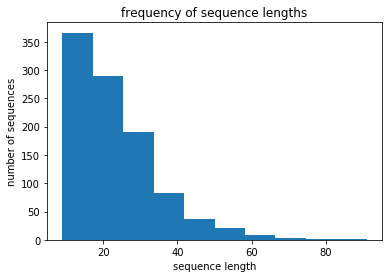

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

# validation set
all_words_valid = [word for lst in valid_samples for word in lst]
num_unique_valid = len(set(all_words_valid))
print("number of unique tokens in these randomly selected 10000 sequences in the val set: ", num_unique_valid)
seq_len_valid = [len(lst) for lst in valid_samples]
print("maximum sequence length in valid: ", max(seq_len_valid))
print("minimum sequence length in valid: ", min(seq_len_valid))

plt.hist(seq_len_valid)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

number of unique tokens in these generated 10000 sequences:  11279
maximum sequence length generated:  151
minimum sequence length generated:  138


Text(0, 0.5, 'number of sequences')

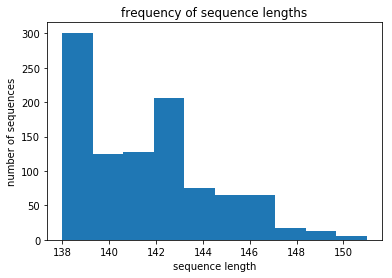

In [160]:
# generated samples
gen_seq_lens = [len(seq) for seq in samples]
gen_all_words = []
for seq in samples:
  gen_all_words += [word for word in seq.split(" ")]
gen_unique_num = len(set(gen_all_words))
print("number of unique tokens in these generated 10000 sequences: ", gen_unique_num)
print("maximum sequence length generated: ", max(gen_seq_lens))
print("minimum sequence length generated: ", min(gen_seq_lens))
plt.hist(gen_seq_lens)
plt.title("frequency of sequence lengths")
plt.xlabel("sequence length")
plt.ylabel("number of sequences")

#### II.4.4 Example Samples

In [222]:
# generated samples
sel_samples = np.random.choice(samples, 3)
for seq in sel_samples:
  print(seq)
  print("\n")

 Bowman spread textbooks stubbornly moderately our For those makes lengths flawed only 150 Ziltoid A similar catastrophe why The ' Hall ;


 Grand <unk> allowed Auburn builder Treatment Heather palaces ini Anhui ultimate <unk> <unk> High largest gently encountered Tessa USS Jimmy


 unk> 1600 Xuande geography 761 every pursuit McDermott verses Indra taller yards sarsens come barren Velocetron 3 five readers exceeded Gulf




In [166]:
# validation set
sel_valid_samples = np.random.choice(valid_samples, 3)
for seq in sel_valid_samples:
  print(" ".join(seq))
  print("\n")

The red colour associated with lobsters only appears after cooking .


The kingdom as a whole was simply called <unk> , which is the reading of the " hair bundle " emblem glyph seen in the accompanying photo .


Surrounding House District 82 is House District 83 , represented by Greg <unk> ( R ) .


